# Decomposition-Residuals Neural Networks: Hybrid system identification applied to electricity forecasting

### Konstantinos Theodorakos
##### Ph.D. student
#### KU Leuven, Belgium
konstantinos.theodorakos@esat.kuleuven.be
##### Dept. of Electrical Engineering (ESAT) – Research Group STADIUS, Center for Dynamical Systems, Signal Processing, and Data Analytics

Code adapted from: https://www.tensorflow.org/tutorials/structured_data/time_series

##### Copyright 2019 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Time series forecasting

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/structured_data/time_series"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/structured_data/time_series.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/time_series.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/structured_data/time_series.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial is an introduction to time series forecasting using TensorFlow. It builds a few different styles of models including Convolutional and Recurrent Neural Networks (CNNs and RNNs).

This is covered in two main parts, with subsections:

* Forecast for a single timestep:
  * A single feature.
  * All features.
* Forecast multiple steps:
  * Single-shot: Make the predictions all at once.
  * Autoregressive: Make one prediction at a time and feed the output back to the model.

## Imports

In [2]:
import os
import gc
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import pandas as pd
import seaborn as sns
import tensorflow as tf
from customTensorflowLayers.DataframeDecompositionLayer import DataframeDecompositionLayer

ModuleNotFoundError: No module named 'matplotlib'

## Settings

In [ ]:
do_DecompositionResiduals = True # DR-DNN or plain DNN
cpu_only = False # CPU or GPU acceleration
do_extras = False # Extras: 3 STD outliers, Day/year sines,
use_real_cepstrum = False
MAX_EPOCHS = 150 # 300 # 500 # 350 # 150 # 20
stop_early_patience = 8
reduce_learning_rate_patience = 5
min_learning_rate_on_plateau= 1e-4
window_stride = 1 # 12 # 24 # 1 # hours
use_stl = True # False for ablation study
use_moving_filters = True # False for ablation study
use_extra_filters = True # False for default DR-DNN

ablation_text = ""
if use_stl == False or use_moving_filters == False:
    use_ablation = True
    if use_stl:
        ablation_text = "_no_moving_filters"
    else:
        ablation_text = "_no_STL"
else:
    use_ablation = False


## Parameters

In [ ]:
mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False
seed = 0

In [ ]:
if cpu_only:
    os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"  # These lines should be called asap, after the os import
    os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  # Use CPU only by default
# gtx1070ti_only = True
# rtx3090_only = False
# if gtx1070ti_only:
#     os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"  # These lines should be called asap, after the os import
#     os.environ["CUDA_VISIBLE_DEVICES"] = "1"  # Use CPU only by default
# if rtx3090_only:
#     os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"  # These lines should be called asap, after the os import
#     os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # Use CPU only by default
if tf.test.gpu_device_name():
    print('GPU found')
else:
    print("No GPU found")

GPU found


In [ ]:
#df = pd.read_csv(csv_path)
# df = pd.read_excel("../../next-dayCOVID-19/data/Actuals.xlsx") # Read from excel
# df = pd.read_excel("../../next-dayCOVID-19/data/ActualsAll.xlsx") # Read from excel
df = pd.read_excel("../../next-dayCOVID-19/data/ActualsAll_8PM.xlsx") # Read from excel
# df = pd.read_excel("../../next-dayCOVID-19/data/ActualsAll_8PM_weather_forecast_48h.xlsx") # Read from excel

# date_time = pd.to_datetime(df.pop('Date Time'), format='%d.%m.%Y %H:%M:%S')
df.index = pd.to_datetime(df.pop('Time'))

# Pre/Post-COVID: first 2.5 years vs last 1 year

In [ ]:
# df = df.head(int(365 * 24 * 2.5)).copy() # Pre-COVID: first 2.5 years
# df = df.tail(int(365 * 24 * 2)).copy() # Post-COVID: last 2 years
# df = df.tail(24 * 30)  # A few samples for quick testing
print(df.shape)
df.tail()

(34360, 7)


,Load (kW),Pressure_kpa,Cloud Cover (%),Humidity (%),Temperature (C),Wind Direction (deg),Wind Speed (kmh)
Time,,,,,,,
2021-02-16 19:00:00.070,1186482.432,1011.20,1.00,56.166667,19.506886,318.50,14.3825
2021-02-16 20:00:00.075,1147712.932,1011.90,0.25,56.000000,19.331886,341.25,9.5850
2021-02-16 21:00:00.080,1121879.432,1012.55,0.25,52.000000,17.751886,341.25,13.3050
2021-02-16 22:00:00.085,1101506.432,1012.60,4.50,50.666667,17.386886,31.25,10.1550
2021-02-16 23:00:00.090,1077974.932,1012.35,7.00,51.000000,16.816886,13.75,7.7200


### Calculate data split indices from pre-calculation of DR

We'll use a `(70%, 20%, 10%)` split for the training, validation, and test sets. Note the data is **not** being randomly shuffled before splitting. This is for two reasons.

1. It ensures that chopping the data into windows of consecutive samples is still possible.
2. It ensures that the validation/test results are more realistic, being evaluated on data collected after the model was trained.

In [ ]:
train_ratio = 0.7 # 0.98  # 0.7
validation_ratio = 0.2 # 0.01  # 0.2
test_ratio = 1 - (train_ratio + validation_ratio)
print("Train/validation/test: {}%/{}%/{}%".format(np.round(train_ratio * 100, 3), np.round(validation_ratio * 100, 3), np.round(test_ratio * 100, 3)))

column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)

Train/validation/test: 70.0%/20.0%/10.0%


# Remove outliers

In [ ]:
# min_z = 3
# z = np.abs(stats.zscore(df))
# print(df.shape)
# print(np.where(z > min_z))
#
# df_clean = df.copy()
# df_clean.loc[(z > min_z).all(axis=1)] = np.nan
# df_clean = df_clean.interpolate("time").bfill().ffill()
# print(df_clean.shape)
# df = df_clean

DR

In [ ]:
def get_DR_df(time_series):
    layer_decomposition = DataframeDecompositionLayer(
        forecast_STL=False, freq="H", period=24, return_dataframe=True,
        endogenous_variables=["Load (kW)",
                              # "Temperature (C) "
                              ],
        multiple_lags=True,
        use_real_cepstrum=use_real_cepstrum,
        use_stl=use_stl,
        use_moving_filters=use_moving_filters,
        use_extra_filters=use_extra_filters
    )
    out_layer_decomposition = layer_decomposition(
        time_series, forecast_STL=False, freq="H", period=24, return_dataframe=True,
        endogenous_variables=["Load (kW)",
                              # "Temperature (C) "
                              ],
        multiple_lags=True,
        use_real_cepstrum=use_real_cepstrum,
        use_stl=use_stl,
        use_moving_filters=use_moving_filters,
        use_extra_filters=use_extra_filters
    )

    return out_layer_decomposition

# TODO: Split preprocessing

## Different on each subset:
1. **train**
2. **train+val**
3. **train+val+test** sequence...

### From the START:
SPLIT data: train, train+val, train+val+test sequence...

#### Then for each subset:

1. Remove 3 STD outliers (optional, affects post-sample).
2. Apply DR (affects post-sample).
3. Feature engineering wind (rolling: not affected post-sample).
4. Add weekly lag (rolling: not affected in-sample).
5. Normalize (on train mean/std) (affects post-sample).

## TODO: IF 7-day lag baseline can't be beaten...

10-iter hyperopt x 10 experiment runs

In [ ]:
%%time
model_type = "No DR"
if do_DecompositionResiduals:

    model_type = "DR-DNN"

    # DR split
    pre_train_df = df[0:int(n*train_ratio)].copy()
    pre_train_val_df = df[0:int(n*(train_ratio + validation_ratio))].copy()
    pre_train_val_test_df = df.copy()

    # Gradual DR fit
    dr_train = get_DR_df(pre_train_df)
    dr_train_val = get_DR_df(pre_train_val_df)
    dr_train_val_test = get_DR_df(pre_train_val_test_df)

    # Replace DR segments of gradual fit: train/val/test
    dr_train_val_test[0:int(n*train_ratio)] = dr_train[0:int(n*train_ratio)]  # Replace with old train decomp
    dr_train_val_test[int(n*train_ratio):int(n*(train_ratio + validation_ratio))] = dr_train_val[int(n*train_ratio):int(n*(train_ratio + validation_ratio))]  # Replace with old val decomp. Test decomp not needed
    df = dr_train_val_test.copy()

date_time = df.index

Wall time: 13.2 s


Let's take a glance at the data. Here are the first few rows:

In [ ]:
print(df.shape)
df.head()

(34360, 29)


,Load (kW),Pressure_kpa,Cloud Cover (%),Humidity (%),Temperature (C),Wind Direction (deg),Wind Speed (kmh),Load (kW)_trend,Load (kW)_seasonal,Load (kW)_resid,...,sin_dayofyear,cos_dayofyear,sin_week,cos_week,weekend,weekday,sin_hour,cos_hour,daytime,nighttime
Time,,,,,,,,,,,,,,,,,,,,,
2017-03-18 08:00:00,1.060602e+06,1011.86875,44.0,77.416667,15.831886,268.375,5.28125,1.093978e+06,-30367.108730,-3009.583883,...,0.96574,0.259512,0.935016,0.354605,1.0,0.0,0.816970,-0.576680,1.0,0.0
2017-03-18 09:00:00,1.141663e+06,1013.41000,44.0,74.333333,19.369386,289.375,7.13375,1.094002e+06,50055.511608,-2394.534363,...,0.96574,0.259512,0.935016,0.354605,1.0,0.0,0.631088,-0.775711,1.0,0.0
2017-03-18 10:00:00,1.195235e+06,1013.54000,44.0,74.333333,21.594386,285.625,14.72375,1.094025e+06,104128.436298,-2918.302773,...,0.96574,0.259512,0.935016,0.354605,1.0,0.0,0.398401,-0.917211,1.0,0.0
2017-03-18 11:00:00,1.208175e+06,1013.08625,44.0,76.250000,22.386886,279.375,16.63125,1.094048e+06,117326.898711,-3199.692977,...,0.96574,0.259512,0.935016,0.354605,1.0,0.0,0.136167,-0.990686,1.0,0.0
2017-03-18 12:00:00,1.216409e+06,1013.58875,44.0,77.916667,21.391886,270.750,13.36375,1.094071e+06,124897.766878,-2559.070548,...,0.96574,0.259512,0.935016,0.354605,1.0,0.0,-0.136167,-0.990686,1.0,0.0


Here is the evolution of a few features over time.

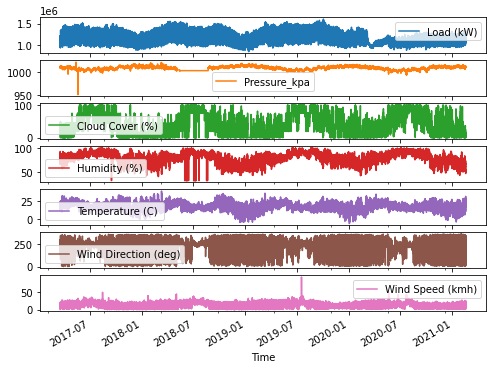

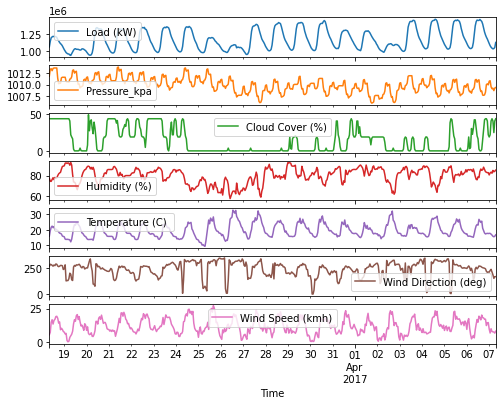

In [ ]:
# plot_cols = ['T (degC)', 'p (mbar)', 'rho (g/m**3)']
plot_cols = ['Load (kW)', 'Pressure_kpa', 'Cloud Cover (%)', 'Humidity (%)',
       'Temperature (C) ', 'Wind Direction (deg)', 'Wind Speed (kmh)']

plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

plot_features = df[plot_cols][:480]
plot_features.index = date_time[:480]
_ = plot_features.plot(subplots=True)

### Inspect and cleanup

Next look at the statistics of the dataset:

In [ ]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Load (kW),34360.0,1.148487e+06,1.483210e+05,8.454714e+05,1.029711e+06,1.112139e+06,1.249680e+06,1.605192e+06
Pressure_kpa,34360.0,1.009425e+03,3.974070e+00,9.505950e+02,1.006350e+03,1.009925e+03,1.012400e+03,1.022915e+03
Cloud Cover (%),34360.0,3.981531e+01,3.236461e+01,0.000000e+00,8.000000e+00,4.087500e+01,7.450000e+01,1.000000e+02
Humidity (%),34360.0,7.958024e+01,1.133911e+01,3.333333e+01,7.200000e+01,8.141667e+01,8.866667e+01,1.000000e+02
Temperature (C),34360.0,1.673184e+01,5.774698e+00,-6.418114e+00,1.343189e+01,1.668189e+01,2.053189e+01,3.906689e+01
Wind Direction (deg),34360.0,2.094470e+02,9.473317e+01,0.000000e+00,1.257500e+02,2.391250e+02,2.856250e+02,3.575000e+02
Wind Speed (kmh),34360.0,1.268949e+01,6.640257e+00,0.000000e+00,7.646250e+00,1.194250e+01,1.771406e+01,9.149750e+01
Load (kW)_trend,34360.0,1.175042e+06,7.801763e+04,9.589879e+05,1.114386e+06,1.183658e+06,1.233019e+06,1.362827e+06
Load (kW)_seasonal,34360.0,2.441879e+01,1.342058e+05,-2.440146e+05,-1.209218e+05,-4.292709e+02,1.307492e+05,2.497567e+05
Load (kW)_resid,34360.0,-2.657960e+04,6.781731e+04,-3.971667e+05,-1.116456e+04,-1.469991e+03,2.382045e+03,2.343911e+05


#### Wind velocity

One thing that should stand out is the `min` value of the wind velocity, `wv (m/s)` and `max. wv (m/s)` columns. This `-9999` is likely erroneous. There's a separate wind direction column, so the velocity should be `>=0`. Replace it with zeros:


In [ ]:
# wv = df['wv (m/s)']
# bad_wv = wv == -9999.0
# wv[bad_wv] = 0.0
#
# max_wv = df['max. wv (m/s)']
# bad_max_wv = max_wv == -9999.0
# max_wv[bad_max_wv] = 0.0
#
# # The above inplace edits are reflected in the DataFrame
# df['wv (m/s)'].min()

### Feature engineering

Before diving in to build a model it's important to understand your data, and be sure that you're passing the model appropriately formatted data.

#### Wind
The last column of the data, `wd (deg)`, gives the wind direction in units of degrees. Angles do not make good model inputs, 360° and 0° should be close to each other, and wrap around smoothly. Direction shouldn't matter if the wind is not blowing.

Right now the distribution of wind data looks like this:

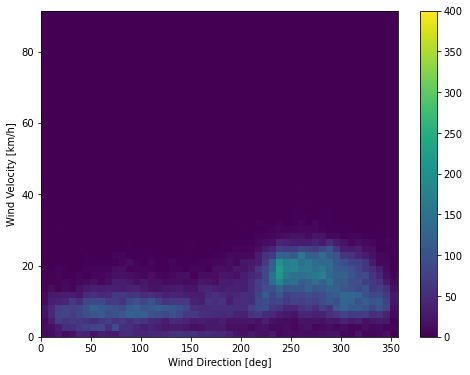

In [ ]:
ax = plt.gca()
ax.axis('tight')
plt.hist2d(df['Wind Direction (deg)'], df['Wind Speed (kmh)'],
           bins=(50, 50),
           vmax=400, # linear normalization
           # range=[[0, 360], [0, 60]],
           # cmap=plt.get_cmap("jet"), # turbo, jet, rainbow
           )
plt.colorbar()

plt.xlabel('Wind Direction [deg]')
plt.ylabel('Wind Velocity [km/h]')
plt.savefig("wind_direction_velocity.svg")
plt.savefig("wind_direction_velocity.png")

But this will be easier for the model to interpret if you convert the wind direction and velocity columns to a wind **vector**:

In [ ]:
wv = df.pop('Wind Speed (kmh)')
# max_wv = df.pop('max. wv (m/s)')

# Convert to radians.
wd_rad = df.pop('Wind Direction (deg)') * np.pi / 180.0

# Calculate the wind x and y components.
df['Wx'] = wv * np.cos(wd_rad)
df['Wy'] = wv * np.sin(wd_rad)

# # Calculate the max wind x and y components.
# df['max Wx'] = max_wv*np.cos(wd_rad)
# df['max Wy'] = max_wv*np.sin(wd_rad)

The distribution of wind vectors is much simpler for the model to correctly interpret.

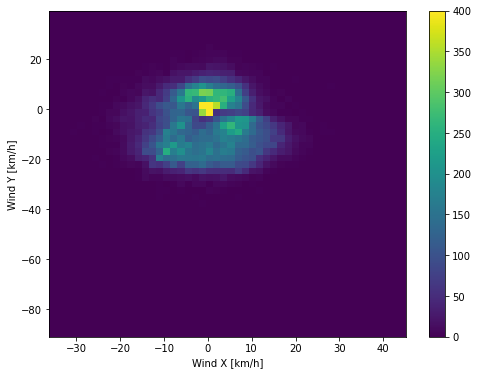

In [ ]:
ax = plt.gca()
ax.axis('tight')
plt.hist2d(df['Wx'], df['Wy'],
              bins=(50, 50),
           # range=[[-60, 60], [-60, 60]],
           # cmap=plt.get_cmap("jet"), # turbo, jet, rainbow
           vmax=400 # linear normalization
           )
plt.colorbar()
plt.xlabel('Wind X [km/h]')
plt.ylabel('Wind Y [km/h]')

plt.savefig("wind_vectors.svg")
plt.savefig("wind_vectors.png")

#### Time

Similarly the `Date Time` column is very useful, but not in this string form. Start by converting it to seconds:

In [ ]:
timestamp_s = date_time.map(datetime.datetime.timestamp)

Similar to the wind direction the time in seconds is not a useful model input. Being weather data it has clear daily and yearly periodicity. There are many ways you could deal with periodicity.

A simple approach to convert it to a usable signal is to use `sin` and `cos` to convert the time to clear "Time of day" and "Time of year" signals:

In [ ]:
if do_DecompositionResiduals and do_extras:
    day = 24*60*60
    year = (365.2425)*day

    df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
    df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
    df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
    df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

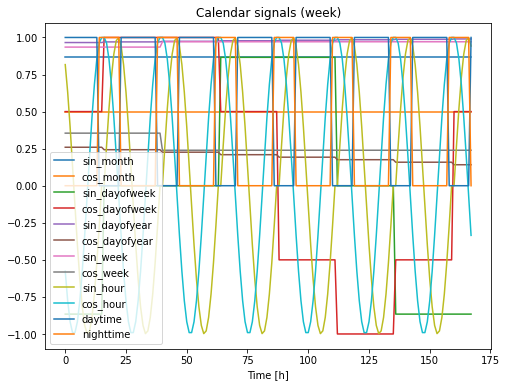

In [ ]:
if do_DecompositionResiduals:
    plot_range = 24 * 7

    legend = []
    for column in df.columns:
        if "cos" in column or "sin" in column or "time" in column:
            plt.plot(np.array(df[column])[:plot_range])
            legend.append(column)
    plt.legend(legend)
    plt.xlabel('Time [h]')
    plt.title('Calendar signals (week)')
    plt.savefig("calendar_DR.svg")
    plt.savefig("calendar_DR.png")
    plt.savefig("calendar_DR.pdf")


This gives the model access to the most important frequency features. In this case you knew ahead of time which frequencies were important.

If you didn't know, you can determine which frequencies are important using an `fft`. To check our assumptions, here is the `tf.signal.rfft` of the temperature over time. Note the obvious peaks at frequencies near `1/year` and `1/day`:

In [ ]:
if do_DecompositionResiduals and do_extras:
    fft = tf.signal.rfft(df['Load (kW)'])
    f_per_dataset = np.arange(0, len(fft))

    n_samples_h = len(df['Load (kW)'])
    hours_per_year = 24*365.2524
    years_per_dataset = n_samples_h/(hours_per_year)

    f_per_year = f_per_dataset/years_per_dataset
    plt.step(f_per_year, np.abs(fft))
    plt.xscale('log')
    plt.ylim(0, 2.5 * 1e9)
    plt.xlim([0.1, max(plt.xlim())])
    plt.xticks([1, 7, 30, 365.2524/4.0, 365.2524], labels=['1/Year', '1/Quarter-year', '1/month', '1/week', '1/day'])
    _ = plt.xlabel('Frequency (log scale)')

### Weekly lag
Repeat signal from exactly 24 hours x 6/7/8 days ago.

In [ ]:
df['Load (kW)_lag7d'] = df['Load (kW)'].shift(24*7).bfill()
df['Load (kW)_lag6d'] = df['Load (kW)'].shift(24*6).bfill()
df['Load (kW)_lag5d'] = df['Load (kW)'].shift(24*5).bfill()

####  Do Split the data

In [ ]:
train_df = df[0:int(n*train_ratio)]
val_df = df[int(n*train_ratio):int(n*(train_ratio + validation_ratio))]
test_df = df[int(n*(train_ratio + validation_ratio)):]

num_features = df.shape[1]

# Plot time periods:
print("Train (", train_df.shape[0], "):\n\t", train_df.head(1).index.values, " to ", train_df.tail(1).index.values)
print("Validation (", val_df.shape[0], "):\n\t", val_df.head(1).index.values, " to ", val_df.tail(1).index.values)
print("Test (", test_df.shape[0], "):\n\t", test_df.head(1).index.values, " to ", test_df.tail(1).index.values)

Train ( 24052 ):
	 ['2017-03-18T08:00:00.000000000']  to  ['2019-12-15T11:00:00.000000000']
Validation ( 6871 ):
	 ['2019-12-15T12:00:00.000000000']  to  ['2020-09-26T18:00:00.000000000']
Test ( 3437 ):
	 ['2020-09-26T19:00:00.000000000']  to  ['2021-02-16T23:00:00.090000000']


### Normalize the data

It is important to scale features before training a neural network. Normalization is a common way of doing this scaling. Subtract the mean and divide by the standard deviation of each feature.

The mean and standard deviation should only be computed using the training data so that the models have no access to the values in the validation and test sets.

It's also arguable that the model shouldn't have access to future values in the training set when training, and that this normalization should be done using moving averages. That's not the focus of this tutorial, and the validation and test sets ensure that you get (somewhat) honest metrics. So in the interest of simplicity this tutorial uses a simple average.

In [ ]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

Now peek at the distribution of the features. Some features do have long tails, but there are no obvious errors like the `-9999` wind velocity value.

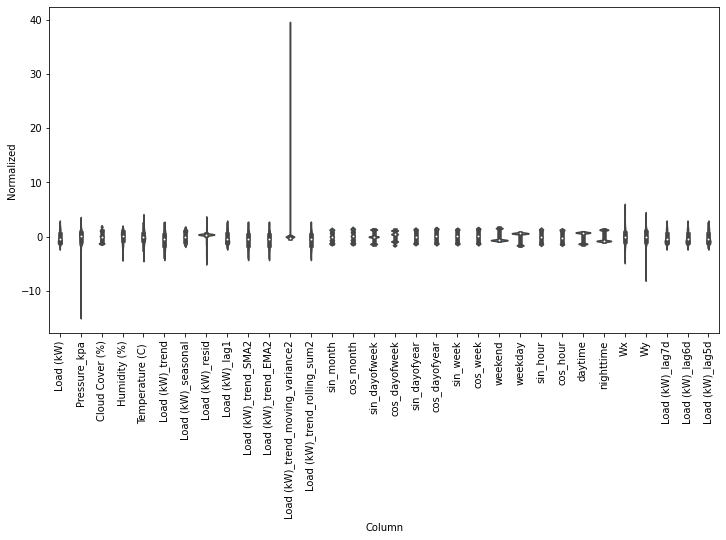

In [ ]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

## Data windowing

The models in this tutorial will make a set of predictions based on a window of consecutive samples from the data.

The main features of the input windows are:

* The width (number of time steps) of the input and label windows
* The time offset between them.
* Which features are used as inputs, labels, or both.

This tutorial builds a variety of models (including Linear, DNN, CNN and RNN models), and uses them for both:

* *Single-output*, and *multi-output* predictions.
* *Single-time-step* and *multi-time-step* predictions.

This section focuses on implementing the data windowing so that it can be reused for all of those models.


Depending on the task and type of model you may want to generate a variety of data windows. Here are some examples:

1. For example, to make a single prediction 24h into the future, given 24h of history you might define a window like this:

  ![One prediction 24h into the future.](images/raw_window_24h.png)

2. A model that makes a prediction 1h into the future, given 6h of history would need a window like this:

  ![One prediction 1h into the future.](images/raw_window_1h.png)

The rest of this section defines a `WindowGenerator` class. This class can:

1. Handle the indexes and offsets as shown in the diagrams above.
2. Split windows of features into a `(features, labels)` pairs.
3.
4. the content of the resulting windows.
5. Efficiently generate batches of these windows from the training, evaluation, and test data, using `tf.data.Dataset`s.

### 1. Indexes and offsets

Start by creating the `WindowGenerator` class. The `__init__` method includes all the necessary logic for the input and label indices.

It also takes the train, eval, and test dataframes as input. These will be converted to `tf.data.Dataset`s of windows later.

In [ ]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

Here is code to create the 2 windows shown in the diagrams at the start of this section:

In [ ]:
w1 = WindowGenerator(input_width=24, label_width=1, shift=24,
                     label_columns=['Load (kW)'])
w1

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [47]
Label column name(s): ['Load (kW)']

In [ ]:
w2 = WindowGenerator(input_width=6, label_width=1, shift=1,
                     label_columns=['Load (kW)'])
w2

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['Load (kW)']

### 2. Split
Given a list consecutive inputs, the `split_window` method will convert them to a window of inputs and a window of labels.

The example `w2`, above, will be split like this:

![The initial window is all consecutive samples, this splits it into an (inputs, labels) pairs](images/split_window.png)

This diagram doesn't show the `features` axis of the data, but this `split_window` function also handles the `label_columns` so it can be used for both the single output and multi-output examples.

In [ ]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

Try it out:

In [ ]:
# Stack three slices, the length of the total window:
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])


example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 7, 32)
Inputs shape: (3, 6, 32)
labels shape: (3, 1, 1)


Typically data in TensorFlow is packed into arrays where the outermost index is across examples (the "batch" dimension). The middle indices are the "time" or "space" (width, height) dimension(s). The innermost indices are the features.

The code above took a batch of 3, 7-timestep windows, with 19 features at each time step. It split them into a batch of 6-timestep, 19 feature inputs, and a 1-timestep 1-feature label. The label only has one feature because the `WindowGenerator` was initialized with `label_columns=['T (degC)']`. Initially this tutorial will build models that predict single output labels.

### 3. Plot

Here is a plot method that allows a simple visualization of the split window:

In [ ]:
w2.example = example_inputs, example_labels

In [ ]:
def plot(self, model=None, plot_col='Load (kW)', model_title=model_type, max_subplots=1):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(3, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Measurements', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')
  plt.title("{} 24h input, 24h-ahead forecast: {}".format(model_title, plot_col))

WindowGenerator.plot = plot

This plot aligns inputs, labels, and (later) predictions based on the time that the item refers to:

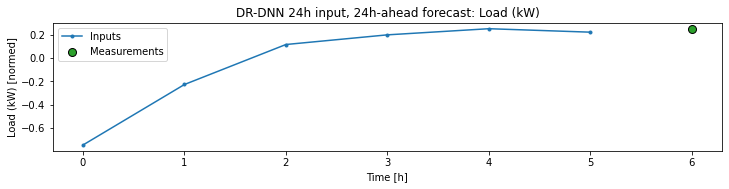

In [ ]:
w2.plot()

You can plot the other columns, but the example window `w2` configuration only has labels for the `T (degC)` column.

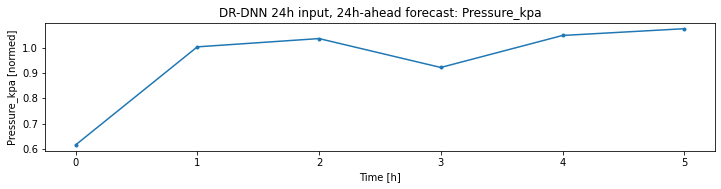

In [ ]:
w2.plot(plot_col='Pressure_kpa')

### 4. Create `tf.data.Dataset`s

Finally this `make_dataset` method will take a time series `DataFrame` and convert it to a `tf.data.Dataset` of `(input_window, label_window)` pairs using the `preprocessing.timeseries_dataset_from_array` function.

In [ ]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=window_stride,
      # shuffle=True,
      shuffle=False,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

The `WindowGenerator` object holds training, validation and test data. Add properties for accessing them as `tf.data.Datasets` using the above `make_dataset` method. Also add a standard example batch for easy access and plotting:

In [ ]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

Now the `WindowGenerator` object gives you access to the `tf.data.Dataset` objects, so you can easily iterate over the data.

The `Dataset.element_spec` property tells you the structure, `dtypes` and shapes of the dataset elements.

In [ ]:
# Each element is an (inputs, label) pair
w2.train.element_spec

(TensorSpec(shape=(None, 6, 32), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

Iterating over a `Dataset` yields concrete batches:

In [ ]:
for example_inputs, example_labels in w2.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 6, 32)
Labels shape (batch, time, features): (32, 1, 1)


## Single step models

The simplest model you can build on this sort of data is one that predicts a single feature's value, 1 timestep (1h) in the future based only on the current conditions.

So start by building models to predict the `T (degC)` value 1h into the future.

![Predict the next time step](images/narrow_window.png)

Configure a `WindowGenerator` object to produce these single-step `(input, label)` pairs:

In [ ]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['Load (kW)'])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['Load (kW)']

The `window` object creates `tf.data.Datasets` from the training, validation, and test sets, allowing you to easily iterate over batches of data.


In [ ]:
for example_inputs, example_labels in single_step_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 1, 32)
Labels shape (batch, time, features): (32, 1, 1)


### Baseline

Before building a trainable model it would be good to have a performance baseline as a point for comparison with the later more complicated models.

This first task is to predict temperature 1h in the future given the current value of all features. The current values include the current temperature.

So start with a model that just returns the current temperature as the prediction, predicting "No change". This is a reasonable baseline since temperature changes slowly. Of course, this baseline will work less well if you make a prediction further in the future.

![Send the input to the output](images/baseline.png)

In [ ]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

Instantiate and evaluate this model:

In [ ]:
baseline = Baseline(label_index=column_indices['Load (kW)'])

baseline.compile(loss=tf.losses.MeanSquaredError(),
# baseline.compile(loss=tf.losses.MeanAbsoluteError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

215/215 [==============================] - 1s 2ms/step - loss: 0.0273 - mean_absolute_error: 0.1146


That printed some performance metrics, but those don't give you a feeling for how well the model is doing.

The `WindowGenerator` has a plot method, but the plots won't be very interesting with only a single sample. So, create a wider `WindowGenerator` that generates windows 24h of consecutive inputs and labels at a time.

The `wide_window` doesn't change the way the model operates. The model still makes predictions 1h into the future based on a single input time step. Here the `time` axis acts like the `batch` axis: Each prediction is made independently with no interaction between time steps.

In [ ]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=['Load (kW)'])

wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['Load (kW)']

This expanded window can be passed directly to the same `baseline` model without any code changes. This is possible because the inputs and labels have the same number of timesteps, and the baseline just forwards the input to the output:

  ![One prediction 1h into the future, ever hour.](images/last_window.png)

In [ ]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 24, 32)
Output shape: (32, 24, 1)


Plotting the baseline model's predictions you can see that it is simply the labels, shifted right by 1h.

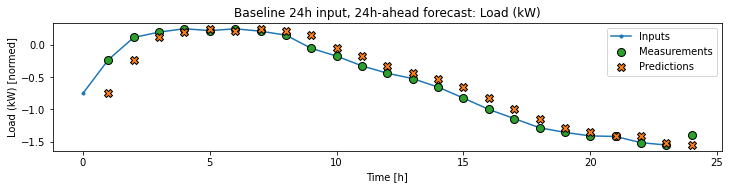

In [ ]:
wide_window.plot(baseline, model_title="Baseline")

In the above plots of three examples the single step model is run over the course of 24h. This deserves some explanation:

* The blue "Inputs" line shows the input temperature at each time step. The model recieves all features, this plot only shows the temperature.
* The green "Labels" dots show the target prediction value. These dots are shown at the prediction time, not the input time. That is why the range of labels is shifted 1 step relative to the inputs.
* The orange "Predictions" crosses are the model's prediction's for each output time step. If the model were predicting perfectly the predictions would land directly on the "labels".

### Linear model

The simplest **trainable** model you can apply to this task is to insert linear transformation between the input and output. In this case the output from a time step only depends on that step:

![A single step prediction](images/narrow_window.png)

A `layers.Dense` with no `activation` set is a linear model. The layer only transforms the last axis of the data from `(batch, time, inputs)` to `(batch, time, units)`, it is applied independently to every item across the `batch` and `time` axes.

In [ ]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

In [ ]:
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', linear(single_step_window.example[0]).shape)

Input shape: (32, 1, 32)
Output shape: (32, 1, 1)


This tutorial trains many models, so package the training procedure into a function:

Helpful functions for experiments:

In [ ]:
def evaluate_denormed(data, df, model, batch_size=32):
    absolute_error = []
    denormed_absolute_error = []

    for batch_inputs, batch_labels in data.take(int(df.shape[0]/batch_size)):

        prediction = model.predict(batch_inputs)
        residuals = tf.abs(batch_labels - prediction)
        absolute_error += residuals.numpy().flatten().tolist()

        denormed_prediction = (prediction * train_std[0]) + train_mean[0]
        denormed_expected = (batch_labels * train_std[0]) + train_mean[0]
        denormed_residuals = tf.abs(denormed_expected - denormed_prediction)
        denormed_absolute_error += denormed_residuals.numpy().flatten().tolist()

    return np.array(absolute_error).mean(), np.array(denormed_absolute_error).mean()

In [ ]:
def evaluate_denormed_sMAPE(data, df, model, batch_size=32):
    denormed_sMAPE = []

    for batch_inputs, batch_labels in data.take(int(df.shape[0]/batch_size)):

        prediction = model.predict(batch_inputs)

        denormed_prediction = (prediction * train_std[0]) + train_mean[0]
        denormed_expected = (batch_labels * train_std[0]) + train_mean[0]

        denormed_residuals = tf.abs(denormed_expected - denormed_prediction)
        denormed_denominator = tf.abs(denormed_expected) + tf.abs(denormed_prediction)

        denormed_pre_sMAPE = 2.0 * (denormed_residuals/denormed_denominator)

        denormed_sMAPE += denormed_pre_sMAPE.numpy().flatten().tolist()
    return 100.0 * np.array(denormed_sMAPE).mean()

In [ ]:
def evaluate_denormed_MAPE(data, df, model, batch_size=32):
    denormed_MAPE = []

    for batch_inputs, batch_labels in data.take(int(df.shape[0]/batch_size)):

        prediction = model.predict(batch_inputs)

        denormed_prediction = (prediction * train_std[0]) + train_mean[0]
        denormed_expected = (batch_labels * train_std[0]) + train_mean[0]

        denormed_residuals = tf.abs(denormed_expected - denormed_prediction)

        denormed_pre_MAPE = (denormed_residuals/denormed_expected)

        denormed_MAPE += denormed_pre_MAPE.numpy().flatten().tolist()

    return 100.0 * np.array(denormed_MAPE).mean()

In [ ]:
def evaluate_denormed_MASE(data, df, model, batch_size=32):
    denormed_MASE = []

    counter = 0
    for batch_inputs, batch_labels in data.take(int(df.shape[0]/batch_size)):

        prediction = model.predict(batch_inputs)

        denormed_prediction = (prediction * train_std[0]) + train_mean[0]
        denormed_expected = (batch_labels * train_std[0]) + train_mean[0]
        denormed_naive_m = (batch_inputs[:, :, 0:1] * train_std[0]) + train_mean[0]

        denormed_residuals = tf.abs(denormed_expected - denormed_prediction)
        denormed_residuals_naive_m = tf.abs(denormed_expected - denormed_naive_m)

        denormed_pre_MASE = (denormed_residuals/denormed_residuals_naive_m)

        denormed_MASE += denormed_pre_MASE.numpy().flatten().tolist()

        # expected = batch_labels
        # naive_m = batch_inputs[:, :, 0:1]
        # residuals = tf.abs(expected - prediction)
        # residuals_naive_m = tf.abs(expected - naive_m)
        # pre_MASE = (residuals/residuals_naive_m)
        # denormed_MASE += pre_MASE.numpy().flatten().tolist()
    return 100.0 * np.array(denormed_MASE).mean()

In [ ]:
def evaluate_denormed_all(data, df, model, batch_size=32, forecast_horizon=24, m_interval=24):

    MAE = []
    denormed_MAE = []
    denormed_sMAPE = []
    denormed_MAPE = []
    denormed_MASE = []

    for batch_inputs, batch_labels in data.take(int(df.shape[0]/batch_size)):

        horizon_batches = batch_inputs.shape[0] * forecast_horizon

        prediction = model.predict(batch_inputs)

        denormed_prediction = (prediction * train_std[0]) + train_mean[0]
        denormed_expected = (batch_labels * train_std[0]) + train_mean[0]
        denormed_errors = denormed_expected - denormed_prediction

        # standardized MAE
        absolute_errors = tf.abs(batch_labels - prediction)
        pre_MAE = tf.math.reduce_sum(absolute_errors)/horizon_batches
        MAE += pre_MAE.numpy().flatten().tolist()

        # MAE
        denormed_absolute_errors = tf.abs(denormed_errors)
        denormed_pre_MAE = tf.math.reduce_sum(denormed_absolute_errors)/horizon_batches
        denormed_MAE += denormed_pre_MAE.numpy().flatten().tolist()

        # MAPE: https://otexts.com/fpp2/accuracy.html
        denormed_pre_MAPE = tf.math.reduce_sum(tf.abs(100 * (denormed_errors/denormed_expected)))/horizon_batches
        denormed_MAPE += denormed_pre_MAPE.numpy().flatten().tolist()

        # sMAPE: M4 contest paper
        denormed_pre_sMAPE = (2 * tf.math.reduce_sum(denormed_absolute_errors/(tf.abs(denormed_expected) + tf.abs(denormed_prediction))))/horizon_batches
        denormed_sMAPE += denormed_pre_sMAPE.numpy().flatten().tolist()

        # MASE: M4 contest paper
        denormed_naive_m = (batch_inputs[:, :, 0:1] * train_std[0]) + train_mean[0]
        denormed_pre_MASE = (denormed_absolute_errors/(tf.abs(denormed_expected - denormed_naive_m)/m_interval)) / horizon_batches

        denormed_MASE += denormed_pre_MASE.numpy().flatten().tolist()

    return np.array(MAE).mean(), np.array(denormed_MAE).mean(), 100.0 * np.array(denormed_sMAPE).mean(), np.array(denormed_MAPE).mean(), np.array(denormed_MASE).mean()

In [ ]:
def delete_model(model):
    """
    Memory Handling: Clear a tensorflow model from memory & with garbage collector.
    :param model: Tensorflow model to remove.
    :return:
    """
    # Memory handling
    del model  # Manually delete model
    tf.compat.v1.reset_default_graph()
    tf.keras.backend.clear_session()
    gc.collect()

In [ ]:
def reload_default_model_weights(model, model_name):
    model.load_weights('{}.h5'.format(model_name))
    return model

In [ ]:
def store_model_weights(model, model_name):
    model.save_weights('{}.h5'.format(model_name))

In [ ]:
def reset_model_weights(model):
    for ix, layer in enumerate(model.layers):
        if hasattr(model.layers[ix], 'kernel_initializer') and hasattr(model.layers[ix], 'bias_initializer'):
            weight_initializer = model.layers[ix].kernel_initializer
            bias_initializer = model.layers[ix].bias_initializer

            old_weights, old_biases = model.layers[ix].get_weights()

            model.layers[ix].set_weights([
            weight_initializer(shape=old_weights.shape),
            bias_initializer(shape=old_biases.shape)])
    return model

In [ ]:
def compile_and_fit(model, window, patience=stop_early_patience,
                    min_learning_rate=min_learning_rate_on_plateau,
                    learning_rate_patience=reduce_learning_rate_patience, verbosity=1):
    early_stopping = tf.keras.callbacks\
        .EarlyStopping(monitor='val_loss', patience=patience, mode='min', restore_best_weights=True, verbose=verbosity)
    reduce_lr = tf.keras.callbacks\
        .ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=learning_rate_patience, min_lr=min_learning_rate, verbose=verbosity)

    # model = reset_model_weights(model)

    model.compile(loss=tf.losses.MeanSquaredError(),
                  optimizer=tf.optimizers.Adam(),
                  metrics=[tf.metrics.MeanAbsoluteError()])

    history = model.fit(window.train, epochs=MAX_EPOCHS, validation_data=window.val,
                        callbacks=[early_stopping, reduce_lr], verbose=verbosity)
    return history

In [ ]:
def compile_store_and_fit(model, window, model_name, patience=stop_early_patience,
                          min_learning_rate=min_learning_rate_on_plateau,
                          learning_rate_patience=reduce_learning_rate_patience, verbosity=1):
    early_stopping = tf.keras.callbacks\
        .EarlyStopping(monitor='val_loss', patience=patience, mode='min', restore_best_weights=True, verbose=verbosity)
    reduce_lr = tf.keras.callbacks\
        .ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=learning_rate_patience, min_lr=min_learning_rate, verbose=verbosity)

    model.compile(loss=tf.losses.MeanSquaredError(),
        optimizer=tf.optimizers.Adam(),
        metrics=[tf.metrics.MeanAbsoluteError()])

    # TODO: store weights first on 1 epoch
    model.fit(window.train, epochs=1, validation_data=window.val, callbacks=[early_stopping])
    print(model.summary())
    store_model_weights(model, model_name)

    history = model.fit(window.train, epochs=MAX_EPOCHS, validation_data=window.val,
                        callbacks=[early_stopping, reduce_lr], verbose=verbosity)
    return history

Train the model and evaluate its performance:

In [ ]:
%%time
history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

Epoch 1/150
752/752 [==============================] - 3s 3ms/step - loss: 0.4638 - mean_absolute_error: 0.4935 - val_loss: 0.1914 - val_mean_absolute_error: 0.3641
Epoch 2/150
752/752 [==============================] - 2s 3ms/step - loss: 0.1073 - mean_absolute_error: 0.2069 - val_loss: 0.0461 - val_mean_absolute_error: 0.1701
Epoch 3/150
752/752 [==============================] - 2s 3ms/step - loss: 0.0499 - mean_absolute_error: 0.1343 - val_loss: 0.0274 - val_mean_absolute_error: 0.1313
Epoch 4/150
752/752 [==============================] - 2s 3ms/step - loss: 0.0277 - mean_absolute_error: 0.1072 - val_loss: 0.0233 - val_mean_absolute_error: 0.1221
Epoch 5/150
752/752 [==============================] - 2s 3ms/step - loss: 0.0171 - mean_absolute_error: 0.0937 - val_loss: 0.0219 - val_mean_absolute_error: 0.1186
Epoch 6/150
752/752 [==============================] - 2s 3ms/step - loss: 0.0122 - mean_absolute_error: 0.0851 - val_loss: 0.0210 - val_mean_absolute_error: 0.1163
Epoch 7/15

Like the `baseline` model, the linear model can be called on batches of wide windows. Used this way the model makes a set of independent predictions on consecutive time steps. The `time` axis acts like another `batch` axis. There are no interactions between the predictions at each time step.

![A single step prediction](images/wide_window.png)

In [ ]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 24, 32)
Output shape: (32, 24, 1)


Here is the plot of its example predictions on the `wide_window`, note how in many cases the prediction is clearly better than just returning the input temperature, but in a few cases it's worse:

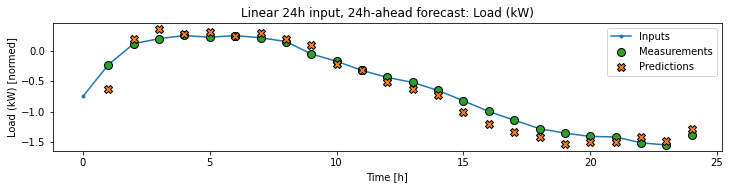

In [ ]:
wide_window.plot(linear, model_title="Linear")

One advantage to linear models is that they're relatively simple to  interpret.
You can pull out the layer's weights, and see the weight assigned to each input:

['Load (kW)', 0.95]
['Load (kW)_trend_EMA2', 0.53]
['Load (kW)_seasonal', 0.49]
['Load (kW)_resid', 0.36]
['sin_week', 0.3]
['Load (kW)_trend', 0.26]
['cos_week', 0.04]
['sin_month', 0.01]
['Load (kW)_lag5d', 0.0]
['Wy', -0.0]
['Wx', -0.0]
['cos_dayofweek', -0.0]
['sin_dayofweek', -0.0]
['cos_month', 0.0]
['Load (kW)_trend_moving_variance2', 0.0]
['Temperature (C) ', -0.0]
['Humidity (%)', 0.0]
['Cloud Cover (%)', -0.0]
['Pressure_kpa', 0.0]
['Load (kW)_lag6d', -0.01]
['Load (kW)_lag7d', -0.01]
['cos_dayofyear', -0.03]
['weekday', -0.05]
['sin_hour', -0.07]
['weekend', -0.07]
['daytime', -0.12]
['nighttime', -0.17]
['cos_hour', -0.17]
['Load (kW)_trend_rolling_sum2', -0.23]
['Load (kW)_trend_SMA2', -0.23]
['sin_dayofyear', -0.31]
['Load (kW)_lag1', -0.76]


Text(0.5, 1.0, 'DR linear: Signal weights of 1st layer ($\\approx \\in [-1, 1]$)')

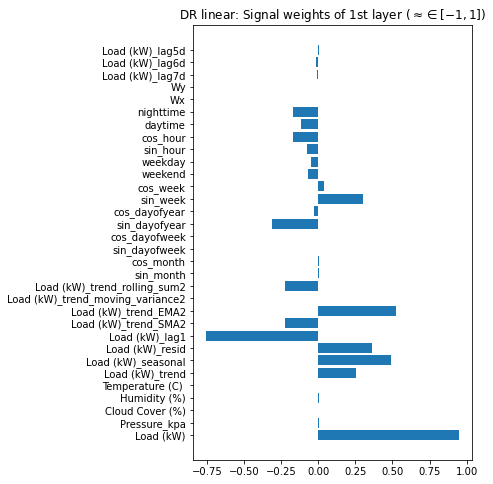

In [ ]:
# plt.bar(x = range(len(train_df.columns)),
#         height=linear.layers[0].kernel[:,0].numpy())
# axis = plt.gca()
# axis.set_xticks(range(len(train_df.columns)))
# _ = axis.set_xticklabels(train_df.columns, rotation=90)

plt.rcParams["figure.figsize"] = [5, 8]
ax = plt.barh(width=linear.layers[0].kernel[:,0].numpy(), y = range(len(train_df.columns)))
axis = plt.gca()
axis.set_yticks(range(len(train_df.columns)))
_ = axis.set_yticklabels(train_df.columns)

l = []
for i in range(len(train_df.columns)):
    l.append([train_df.columns[i], round(linear.layers[0].kernel[:,0].numpy()[i], 2)])
l.sort(key= lambda x: x[1])
l.reverse()
for l1 in l:
    print(l1)
plt.title("DR linear: Signal weights of 1st layer ($\\approx \\in [-1, 1]$)")

In [ ]:
linear.layers[0].kernel[:,0].numpy()[i]

0.0032156503

Sometimes the model doesn't even place the most weight on the input `T (degC)`. This is one of the risks of random initialization.

## Multi-step models

Both the single-output and multiple-output models in the previous sections made **single time step predictions**, 1h into the future.

This section looks at how to expand these models to make **multiple time step predictions**.

In a multi-step prediction, the model needs to learn to predict a range of future values. Thus, unlike a single step model, where only a single future point is predicted, a multi-step model predicts a sequence of the future values.

There are two rough approaches to this:

1. Single shot predictions where the entire time series is predicted at once.
2. Autoregressive predictions where the model only makes single step predictions and its output is fed back as its input.

In this section all the models will predict **all the features across all output time steps**.


For the multi-step model, the training data again consists of hourly samples. However, here, the models will learn to predict 24h of the future, given 24h of the past.

Here is a `Window` object that generates these slices from the dataset:

In [ ]:
seed += 1
tf.random.set_seed(seed)

MISO window
Inputs shape (batch, time, features): (32, 24, 32)
Labels shape (batch, time, features): (32, 24, 1)


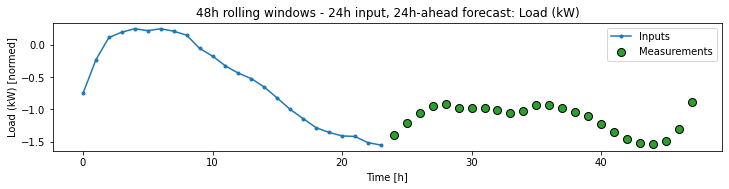

In [ ]:
OUT_STEPS = 24
mode = "MISO"  # MIMO
INPUT_WIDTH = 24

if mode == "MIMO":
    print("MIMO window")
    multi_window = WindowGenerator(input_width=INPUT_WIDTH,
                                   label_width=OUT_STEPS,
                                   shift=OUT_STEPS)
else:
    print("MISO window")
    multi_window = WindowGenerator(input_width=INPUT_WIDTH,
                                   label_width=OUT_STEPS,
                                   shift=OUT_STEPS,
                                   label_columns=['Load (kW)'])
    num_features = 1

multi_window.plot(model_title="48h rolling windows -")
multi_window

for example_inputs, example_labels in multi_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

### Baselines

A simple baseline for this task is to repeat the last input time step for the required number of output timesteps:

![Repeat the last input, for each output step](images/multistep_last.png)

214/214 [==============================] - 0s 2ms/step - loss: 1.6662 - mean_absolute_error: 1.0425
MAE: 32.38, Denormed MAE: 5028220.98 sMAPE%: 445.25%, MAPE%: 467.61%, MASE: 2.77


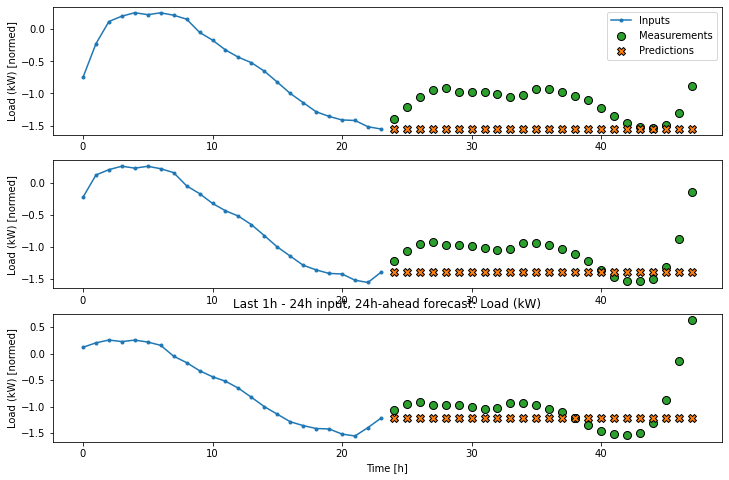

In [ ]:
class MultiStepLastBaseline(tf.keras.Model):
  def call(self, inputs):
    return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])

last_baseline = MultiStepLastBaseline()
last_baseline.compile(loss=tf.losses.MeanSquaredError(),
# last_baseline.compile(loss=tf.losses.MeanAbsoluteError(),
                      metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance = {}
multi_performance = {}

multi_val_performance['Last'] = last_baseline.evaluate(multi_window.val)
multi_performance['Last'] = last_baseline.evaluate(multi_window.test, verbose=0)
standardized_MAE, MAE, sMAPE, MAPE, MASE = \
    evaluate_denormed_all(multi_window.test, multi_window.test_df, last_baseline)
print("MAE: {}, Denormed MAE: {} sMAPE%: {}%, MAPE%: {}%, MASE: {}"
      .format(round(standardized_MAE, 2), round(MAE, 2), round(sMAPE, 2), round(MAPE, 2), round(MASE, 2)))
multi_window.plot(last_baseline, model_title="Last 1h -", max_subplots=3)

Since this task is to predict 24h given 24h another simple approach is to repeat the previous day, assuming tomorrow will be similar:

![Repeat the previous day](images/multistep_repeat.png)


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unable to locate the source code of <bound method RepeatBaseline.call of <__main__.RepeatBaseline object at 0x0000025B58B697F0>>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unable to locate the source code of <bound method RepeatBaseline.call of <__main__.RepeatBaseline obj

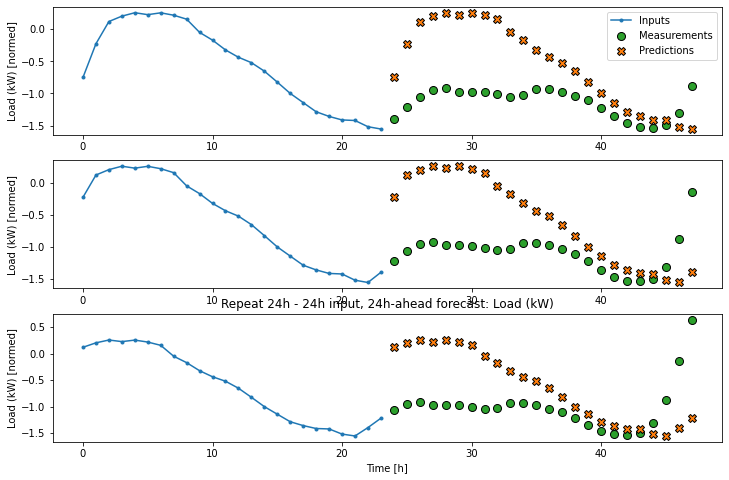

In [ ]:
%%time
class RepeatBaseline(tf.keras.Model):
  def call(self, inputs):
    return inputs[:, -OUT_STEPS:, :]

repeat_baseline = RepeatBaseline()
repeat_baseline.compile(loss=tf.losses.MeanSquaredError(),
# repeat_baseline.compile(loss=tf.losses.MeanAbsoluteError(),
                        metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance['Repeat'] = repeat_baseline.evaluate(multi_window.val)
multi_performance['Repeat'] = repeat_baseline.evaluate(multi_window.test, verbose=0)
standardized_MAE, MAE, sMAPE, MAPE, MASE = \
    evaluate_denormed_all(multi_window.test, multi_window.test_df, repeat_baseline)
print("MAE: {}, Denormed MAE: {} sMAPE%: {}%, MAPE%: {}%, MASE: {}"
      .format(round(standardized_MAE, 2), round(MAE, 2), round(sMAPE, 2), round(MAPE, 2), round(MASE, 2)))
multi_window.plot(repeat_baseline, model_title="Repeat 24h -", max_subplots=3)

Repeat 24h:

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unable to locate the source code of <bound method Repeat24hBaseline.call of <__main__.Repeat24hBaseline object at 0x00000261182C1580>>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unable to locate the source code of <bound method Repeat24hBaseline.call of <__main__.Repeat24h

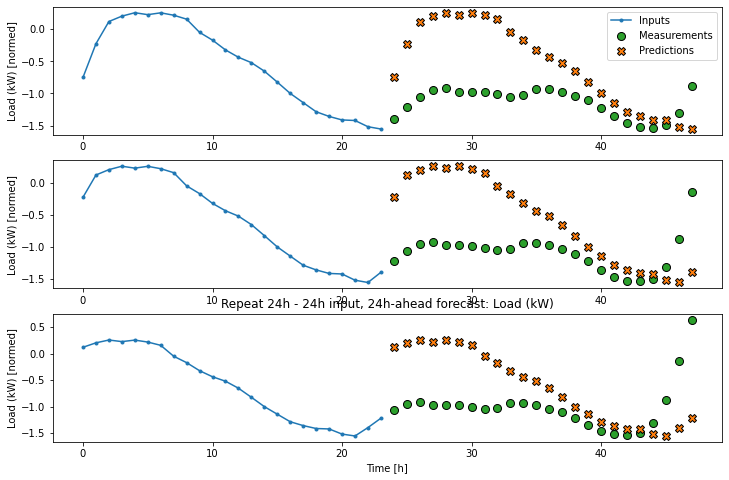

In [ ]:
%%time
# SMA_index = list(multi_window.test_df.columns).index([l for l in multi_window.test_df.columns.to_list() if "SMA" in l][0])
repeat24_index = 0
class Repeat24hBaseline(tf.keras.Model):
  def call(self, inputs):
    feature_count = inputs.shape[2]
    # return inputs[:, :, SMA_index-19:feature_count-18]
    return inputs[:, :, repeat24_index:repeat24_index+1]

repeat24h_baseline = Repeat24hBaseline()
repeat24h_baseline.compile(loss=tf.losses.MeanSquaredError(),
# repeat_7d24h_baseline.compile(loss=tf.losses.MeanAbsoluteError(),
                        metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance['Repeat24h'] = repeat24h_baseline.evaluate(multi_window.val)
multi_performance['Repeat24h'] = repeat24h_baseline.evaluate(multi_window.test, verbose=0)
standardized_MAE, MAE, sMAPE, MAPE, MASE = \
    evaluate_denormed_all(multi_window.test, multi_window.test_df, repeat24h_baseline)
print("MAE: {}, Denormed MAE: {} sMAPE%: {}%, MAPE%: {}%, MASE: {}"
      .format(round(standardized_MAE, 2), round(MAE, 2), round(sMAPE, 2), round(MAPE, 2), round(MASE, 2)))
multi_window.plot(repeat24h_baseline, model_title="Repeat 24h -", max_subplots=3)

Repeat 24 hours from 6 days ago:

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unable to locate the source code of <bound method Repeat6d24hBaseline.call of <__main__.Repeat6d24hBaseline object at 0x0000025B58CA4A00>>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unable to locate the source code of <bound method Repeat6d24hBaseline.call of <__main__.Rep

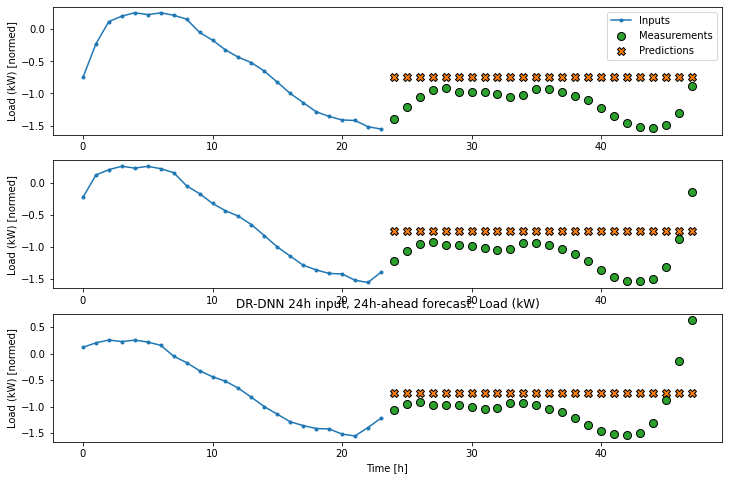

In [ ]:
%%time
class Repeat6d24hBaseline(tf.keras.Model):
  def call(self, inputs):
    feature_count = inputs.shape[2]
    return inputs[:, :, feature_count-1:feature_count]

repeat_6d24h_baseline = Repeat6d24hBaseline()
repeat_6d24h_baseline.compile(loss=tf.losses.MeanSquaredError(),
# repeat_6d24h_baseline.compile(loss=tf.losses.MeanAbsoluteError(),
                        metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance['Repeat6d24h'] = repeat_6d24h_baseline.evaluate(multi_window.val)
multi_performance['Repeat6d24h'] = repeat_6d24h_baseline.evaluate(multi_window.test, verbose=0)
standardized_MAE, MAE, sMAPE, MAPE, MASE = \
    evaluate_denormed_all(multi_window.test, multi_window.test_df, repeat_6d24h_baseline)
print("MAE: {}, Denormed MAE: {} sMAPE%: {}%, MAPE%: {}%, MASE: {}"
      .format(round(standardized_MAE, 2), round(MAE, 2), round(sMAPE, 2), round(MAPE, 2), round(MASE, 2)))
multi_window.plot(repeat_6d24h_baseline, max_subplots=3)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unable to locate the source code of <bound method Repeat7d24hBaseline.call of <__main__.Repeat7d24hBaseline object at 0x0000025B58E35D00>>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unable to locate the source code of <bound method Repeat7d24hBaseline.call of <__main__.Rep

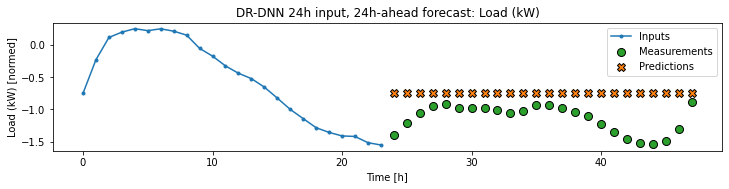

In [ ]:
%%time
class Repeat7d24hBaseline(tf.keras.Model):
  def call(self, inputs):
    feature_count = inputs.shape[2]
    return inputs[:, :, feature_count-2:feature_count-1]

repeat_7d24h_baseline = Repeat7d24hBaseline()
repeat_7d24h_baseline.compile(loss=tf.losses.MeanSquaredError(),
# repeat_7d24h_baseline.compile(loss=tf.losses.MeanAbsoluteError(),
                        metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance['Repeat7d24h'] = repeat_7d24h_baseline.evaluate(multi_window.val)
multi_performance['Repeat7d24h'] = repeat_7d24h_baseline.evaluate(multi_window.test, verbose=0)
standardized_MAE, MAE, sMAPE, MAPE, MASE = \
    evaluate_denormed_all(multi_window.test, multi_window.test_df, repeat_7d24h_baseline)
print("MAE: {}, Denormed MAE: {} sMAPE%: {}%, MAPE%: {}%, MASE: {}"
      .format(round(standardized_MAE, 2), round(MAE, 2), round(sMAPE, 2), round(MAPE, 2), round(MASE, 2)))
multi_window.plot(repeat_7d24h_baseline)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unable to locate the source code of <bound method Repeat8d24hBaseline.call of <__main__.Repeat8d24hBaseline object at 0x000002610FB420D0>>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unable to locate the source code of <bound method Repeat8d24hBaseline.call of <__main__.Rep

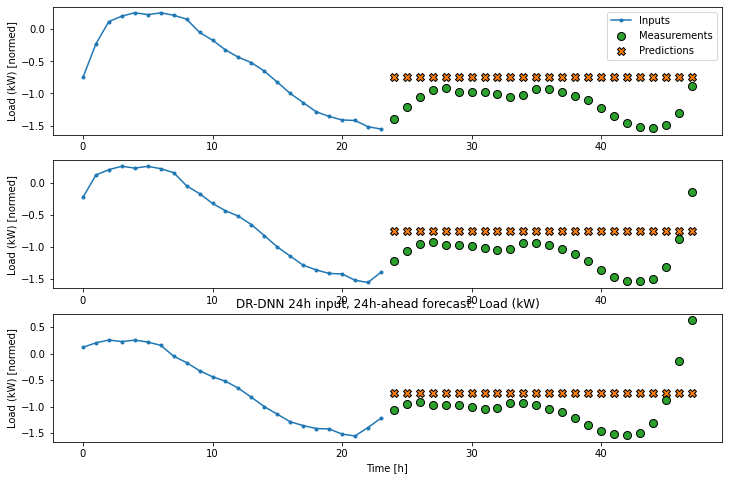

In [ ]:
%%time
class Repeat8d24hBaseline(tf.keras.Model):
  def call(self, inputs):
    feature_count = inputs.shape[2]
    return inputs[:, :, feature_count-3:feature_count-2]

repeat_8d24h_baseline = Repeat8d24hBaseline()
repeat_8d24h_baseline.compile(loss=tf.losses.MeanSquaredError(),
# repeat_8d24h_baseline.compile(loss=tf.losses.MeanAbsoluteError(),
                        metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance['Repeat8d24h'] = repeat_8d24h_baseline.evaluate(multi_window.val)
multi_performance['Repeat8d24h'] = repeat_8d24h_baseline.evaluate(multi_window.test, verbose=0)
standardized_MAE, MAE, sMAPE, MAPE, MASE = \
    evaluate_denormed_all(multi_window.test, multi_window.test_df, repeat_8d24h_baseline)
print("MAE: {}, Denormed MAE: {} sMAPE%: {}%, MAPE%: {}%, MASE: {}"
      .format(round(standardized_MAE, 2), round(MAE, 2), round(sMAPE, 2), round(MAPE, 2), round(MASE, 2)))
multi_window.plot(repeat_8d24h_baseline, max_subplots=3)

SMA:

In [ ]:
multi_window.test_df.columns

Index(['Load (kW)', 'Pressure_kpa', 'Cloud Cover (%)', 'Humidity (%)',
       'Temperature (C) ', 'Load (kW)_trend', 'Load (kW)_seasonal',
       'Load (kW)_resid', 'Load (kW)_lag1', 'Load (kW)_trend_SMA2',
       'Load (kW)_trend_EMA2', 'Load (kW)_trend_moving_variance2',
       'Load (kW)_trend_rolling_sum2', 'sin_month', 'cos_month',
       'sin_dayofweek', 'cos_dayofweek', 'sin_dayofyear', 'cos_dayofyear',
       'sin_week', 'cos_week', 'weekend', 'weekday', 'sin_hour', 'cos_hour',
       'daytime', 'nighttime', 'Wx', 'Wy', 'Load (kW)_lag7d',
       'Load (kW)_lag6d', 'Load (kW)_lag5d'],
      dtype='object')

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unable to locate the source code of <bound method SMABaseline.call of <__main__.SMABaseline object at 0x0000025B58CBF580>>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unable to locate the source code of <bound method SMABaseline.call of <__main__.SMABaseline object at 0x000

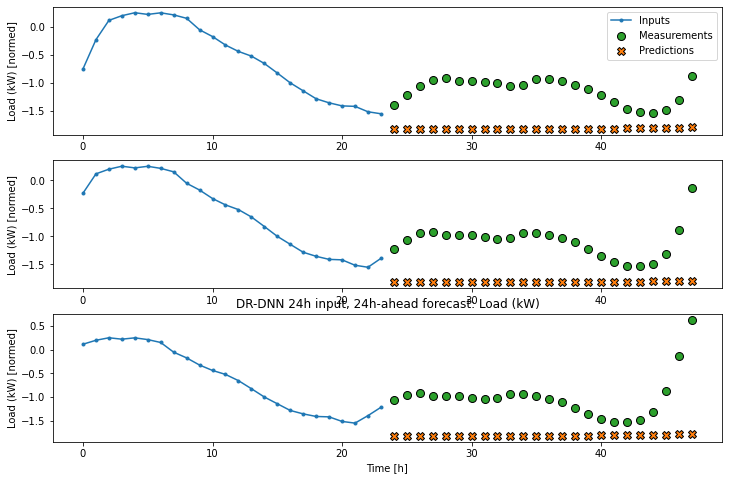

In [ ]:
%%time
SMA_index = list(multi_window.test_df.columns).index([l for l in multi_window.test_df.columns.to_list() if "SMA" in l][0])
class SMABaseline(tf.keras.Model):
  def call(self, inputs):
    feature_count = inputs.shape[2]
    # return inputs[:, :, SMA_index-19:feature_count-18]
    return inputs[:, :, SMA_index:SMA_index+1]

sma_baseline = SMABaseline()
sma_baseline.compile(loss=tf.losses.MeanSquaredError(),
# repeat_7d24h_baseline.compile(loss=tf.losses.MeanAbsoluteError(),
                        metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance['SMA'] = sma_baseline.evaluate(multi_window.val)
multi_performance['SMA'] = sma_baseline.evaluate(multi_window.test, verbose=0)
standardized_MAE, MAE, sMAPE, MAPE, MASE = \
    evaluate_denormed_all(multi_window.test, multi_window.test_df, sma_baseline)
print("MAE: {}, Denormed MAE: {} sMAPE%: {}%, MAPE%: {}%, MASE: {}"
      .format(round(standardized_MAE, 2), round(MAE, 2), round(sMAPE, 2), round(MAPE, 2), round(MASE, 2)))
multi_window.plot(sma_baseline, max_subplots=3)

EMA:

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unable to locate the source code of <bound method EMABaseline.call of <__main__.EMABaseline object at 0x0000026117450A30>>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unable to locate the source code of <bound method EMABaseline.call of <__main__.EMABaseline object at 0x000

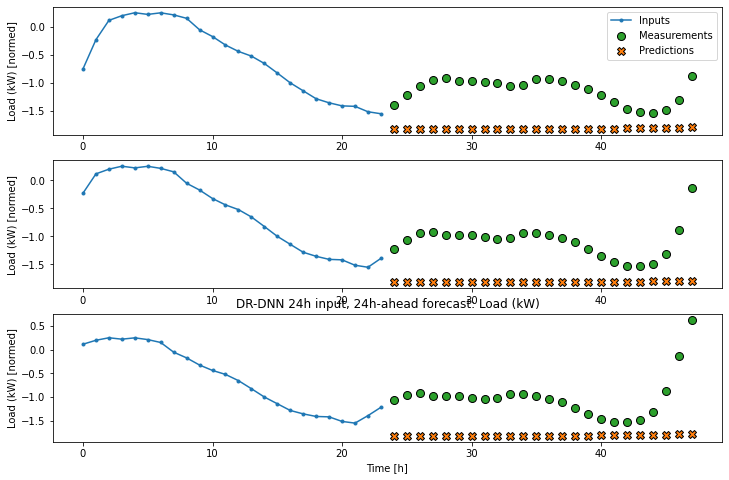

In [ ]:
%%time
if use_extra_filters:
    EMA_index = list(multi_window.test_df.columns).index([l for l in multi_window.test_df.columns.to_list() if "EMA" in l][0])
    class EMABaseline(tf.keras.Model):
      def call(self, inputs):
        feature_count = inputs.shape[2]
        return inputs[:, :, EMA_index:EMA_index+1]

    ema_baseline = EMABaseline()
    ema_baseline.compile(loss=tf.losses.MeanSquaredError(),
    # repeat_7d24h_baseline.compile(loss=tf.losses.MeanAbsoluteError(),
                            metrics=[tf.metrics.MeanAbsoluteError()])

    multi_val_performance['EMA'] = ema_baseline.evaluate(multi_window.val)
    multi_performance['EMA'] = ema_baseline.evaluate(multi_window.test, verbose=0)
    standardized_MAE, MAE, sMAPE, MAPE, MASE = \
        evaluate_denormed_all(multi_window.test, multi_window.test_df, ema_baseline)
    print("MAE: {}, Denormed MAE: {} sMAPE%: {}%, MAPE%: {}%, MASE: {}"
          .format(round(standardized_MAE, 2), round(MAE, 2), round(sMAPE, 2), round(MAPE, 2), round(MASE, 2)))
    multi_window.plot(ema_baseline, max_subplots=3)

In [ ]:
def evaluate_denormed_all_numpy(inputed, expected, predicted, m_interval=24):

    MAE = []
    denormed_MAE = []
    denormed_sMAPE = []
    denormed_MAPE = []
    MAPE = []
    denormed_MASE = []
    hours = len(expected)
    horizon_batches = m_interval

    for i in range(hours):

        prediction = predicted[i]
        expectation = expected[i]
        inputs = inputed[i]

        denormed_prediction = (prediction * train_std[0]) + train_mean[0]
        denormed_expectation = (expectation * train_std[0]) + train_mean[0]
        denormed_inputs = (inputs * train_std[0]) + train_mean[0]
        denormed_errors = denormed_expectation - denormed_prediction

        # standardized MAE
        MAE.append(np.mean(np.abs(expectation - prediction)))

        # MAE
        denormed_absolute_errors = np.abs(denormed_errors)
        denormed_MAE.append(np.mean(np.abs(denormed_expectation - denormed_prediction)))

        # MAPE: https://otexts.com/fpp2/accuracy.html
        denormed_MAPE.append(np.sum(np.abs(100 * (denormed_errors/denormed_expectation)))/horizon_batches)
        MAPE.append(np.sum(np.abs(100 * ((expectation - prediction)/expectation)))/horizon_batches)

        # sMAPE: M4 contest paper
        denormed_sMAPE.append((2 * np.sum(denormed_absolute_errors/(np.abs(denormed_expectation) + np.abs(denormed_prediction))))/horizon_batches)

        # MASE: M4 contest paper
        denormed_naive_m = denormed_inputs
        # denormed_MASE.append((denormed_absolute_errors/(np.abs(denormed_expectation - denormed_naive_m)/m_interval)) / horizon_batches)
        denormed_MASE.append((denormed_absolute_errors/(np.abs(denormed_expectation - denormed_naive_m))) / horizon_batches)

    return np.array(MAE).mean(), np.array(denormed_MAE).mean(), 100.0 * np.array(denormed_sMAPE).mean(), np.array(denormed_MAPE).mean(), np.array(denormed_MASE).mean(), np.array(MAPE).mean()

ARIMA24h

In [ ]:
%%time
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

hours = multi_window.test_df.shape[0] # 4 # 3437
expected = []
predicted = []
denormed_expected = []
denormed_predicted = []
inputed = []
stride = 1
forecasting_window = 24
arima_window = multi_window.val_df['Load (kW)'].values  # Validation data only
# arima_window = multi_window.val_df['Load (kW)'].tail(24).values  # Validation data only
# arima_window = multi_window.train_df['Load (kW)'].append(multi_window.val_df['Load (kW)']).values  # Train + validation data
# arima_rolling_length = 24 * 30 * 3  # Past 3 months
arima_rolling_length = 24  # Past 24 hours

for i in range(hours):
    rolling_input = multi_window.test_df['Load (kW)'].head(i).tail(stride).values
    arima_window = np.append(arima_window, rolling_input)
    arima_window = arima_window[-arima_rolling_length:]
    expected_window = multi_window.test_df['Load (kW)'].head(i + forecasting_window).tail(forecasting_window).values
    p, d, q = 2, 0, 2
    arima_model = ARIMA(arima_window, order=(p, d, q))
    arima_model_fit = arima_model.fit()
    predicted_window = arima_model_fit.forecast(forecasting_window)

    predicted.append(predicted_window)
    expected.append(expected_window)
    inputed.append(arima_window[-forecasting_window:])
    denormed_predicted.append((predicted_window * train_std[0]) + train_mean[0])
    denormed_expected.append((expected_window * train_std[0]) + train_mean[0])

standardized_MAE, MAE, sMAPE, MAPE, MASE, standardized_MAPE = \
    evaluate_denormed_all_numpy(inputed, expected, predicted, m_interval=24)
print("MAE: {}, Denormed MAE: {} sMAPE%: {}%, MAPE%: {}%, MASE: {}, standardized MAPE: {}%"
      .format(round(standardized_MAE, 2), round(MAE, 2), round(sMAPE, 2), round(MAPE, 2), round(MASE, 2), round(standardized_MAPE, 2)))
print("Sklearn MAE:", round(mean_absolute_error(expected, predicted), 2), "MAPE%:", round(mean_absolute_percentage_error(expected, predicted) * 100, 2), "%")
print("Sklearn MAE denormed:", round(mean_absolute_error(denormed_expected, denormed_predicted), 2), "MAPE%:", round(mean_absolute_percentage_error(denormed_expected, denormed_predicted) * 100, 2), "%")
#multi_window.plot(sma_baseline, max_subplots=3)

MAE: 0.48, Denormed MAE: 74239.29 sMAPE%: 6.75%, MAPE%: 6.75%, MASE: 44.9, standardized MAPE: 343.07%
Sklearn MAE: 0.48 MAPE%: 343.07 %
Sklearn MAE denormed: 74239.29 MAPE%: 6.75 %
Wall time: 7min 8s


In [ ]:
standardized_MAE, MAE, sMAPE, MAPE, MASE, standardized_MAPE = \
    evaluate_denormed_all_numpy(inputed, expected, predicted, m_interval=24)
print("MAE: {}, Denormed MAE: {} sMAPE%: {}%, MAPE%: {}%, MASE: {}, standardized MAPE: {}%"
      .format(round(standardized_MAE, 2), round(MAE, 2), round(sMAPE, 2), round(MAPE, 2), round(MASE, 2), round(standardized_MAPE, 2)))
print("Sklearn MAE:", round(mean_absolute_error(expected, predicted), 2), "MAPE%:", round(mean_absolute_percentage_error(expected, predicted) * 100, 2), "%")
print("Sklearn MAE denormed:", round(mean_absolute_error(denormed_expected, denormed_predicted), 2), "MAPE%:", round(mean_absolute_percentage_error(denormed_expected, denormed_predicted) * 100, 2), "%")
#multi_window.plot(sma_baseline, max_subplots=3)

MAE: 0.48, Denormed MAE: 74239.29 sMAPE%: 6.75%, MAPE%: 6.75%, MASE: 1.87, standardized MAPE: 343.07%
Sklearn MAE: 0.48 MAPE%: 343.07 %
Sklearn MAE denormed: 74239.29 MAPE%: 6.75 %


ARIMA30d:

In [ ]:
%%time
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

hours = multi_window.test_df.shape[0] # 4 # 3437
expected = []
predicted = []
denormed_expected = []
denormed_predicted = []
inputed = []
stride = 1
forecasting_window = 24
arima_window = multi_window.val_df['Load (kW)'].values  # Validation data only
# arima_window = multi_window.val_df['Load (kW)'].tail(24).values  # Validation data only
# arima_window = multi_window.train_df['Load (kW)'].append(multi_window.val_df['Load (kW)']).values  # Train + validation data
# arima_rolling_length = 24 * 30 * 3  # Past 3 months
arima_rolling_length = 24 * 30  # Past month

for i in range(hours):
    rolling_input = multi_window.test_df['Load (kW)'].head(i).tail(stride).values
    arima_window = np.append(arima_window, rolling_input)
    arima_window = arima_window[-arima_rolling_length:]
    expected_window = multi_window.test_df['Load (kW)'].head(i + forecasting_window).tail(forecasting_window).values
    p, d, q = 2, 0, 2
    arima_model = ARIMA(arima_window, order=(p, d, q))
    arima_model_fit = arima_model.fit()
    predicted_window = arima_model_fit.forecast(forecasting_window)

    predicted.append(predicted_window)
    expected.append(expected_window)
    inputed.append(arima_window[-forecasting_window:])
    denormed_predicted.append((predicted_window * train_std[0]) + train_mean[0])
    denormed_expected.append((expected_window * train_std[0]) + train_mean[0])

standardized_MAE, MAE, sMAPE, MAPE, MASE, standardized_MAPE = \
    evaluate_denormed_all_numpy(inputed, expected, predicted, m_interval=24)
print("MAE: {}, Denormed MAE: {} sMAPE%: {}%, MAPE%: {}%, MASE: {}, standardized MAPE: {}%"
      .format(round(standardized_MAE, 2), round(MAE, 2), round(sMAPE, 2), round(MAPE, 2), round(MASE, 2), round(standardized_MAPE, 2)))
print("Sklearn MAE:", round(mean_absolute_error(expected, predicted), 2), "MAPE%:", round(mean_absolute_percentage_error(expected, predicted) * 100, 2), "%")
print("Sklearn MAE denormed:", round(mean_absolute_error(denormed_expected, denormed_predicted), 2), "MAPE%:", round(mean_absolute_percentage_error(denormed_expected, denormed_predicted) * 100, 2), "%")
#multi_window.plot(sma_baseline, max_subplots=3)

MAE: 0.45, Denormed MAE: 69593.59 sMAPE%: 6.34%, MAPE%: 6.33%, MASE: 1.72, standardized MAPE: 295.71%
Sklearn MAE: 0.45 MAPE%: 295.71 %
Sklearn MAE denormed: 69593.59 MAPE%: 6.33 %
Wall time: 28min 15s


ARIMA90d:

In [ ]:
%%time
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

hours = multi_window.test_df.shape[0] # 4 # 3437
expected = []
predicted = []
denormed_expected = []
denormed_predicted = []
inputed = []
stride = 1
forecasting_window = 24
arima_window = multi_window.val_df['Load (kW)'].values  # Validation data only
# arima_window = multi_window.val_df['Load (kW)'].tail(24).values  # Validation data only
# arima_window = multi_window.train_df['Load (kW)'].append(multi_window.val_df['Load (kW)']).values  # Train + validation data
arima_rolling_length = 24 * 30 * 3  # Past 3 months
# arima_rolling_length = 24 * 30  # Past month

for i in range(hours):
    rolling_input = multi_window.test_df['Load (kW)'].head(i).tail(stride).values
    arima_window = np.append(arima_window, rolling_input)
    arima_window = arima_window[-arima_rolling_length:]
    expected_window = multi_window.test_df['Load (kW)'].head(i + forecasting_window).tail(forecasting_window).values
    p, d, q = 2, 0, 2
    arima_model = ARIMA(arima_window, order=(p, d, q))
    arima_model_fit = arima_model.fit()
    predicted_window = arima_model_fit.forecast(forecasting_window)

    predicted.append(predicted_window)
    expected.append(expected_window)
    inputed.append(arima_window[-forecasting_window:])
    denormed_predicted.append((predicted_window * train_std[0]) + train_mean[0])
    denormed_expected.append((expected_window * train_std[0]) + train_mean[0])

standardized_MAE, MAE, sMAPE, MAPE, MASE, standardized_MAPE = \
    evaluate_denormed_all_numpy(inputed, expected, predicted, m_interval=24)
print("MAE: {}, Denormed MAE: {} sMAPE%: {}%, MAPE%: {}%, MASE: {}, standardized MAPE: {}%"
      .format(round(standardized_MAE, 2), round(MAE, 2), round(sMAPE, 2), round(MAPE, 2), round(MASE, 2), round(standardized_MAPE, 2)))
print("Sklearn MAE:", round(mean_absolute_error(expected, predicted), 2), "MAPE%:", round(mean_absolute_percentage_error(expected, predicted) * 100, 2), "%")
print("Sklearn MAE denormed:", round(mean_absolute_error(denormed_expected, denormed_predicted), 2), "MAPE%:", round(mean_absolute_percentage_error(denormed_expected, denormed_predicted) * 100, 2), "%")
#multi_window.plot(sma_baseline, max_subplots=3)

MAE: 0.45, Denormed MAE: 69423.66 sMAPE%: 6.32%, MAPE%: 6.28%, MASE: 1.83, standardized MAPE: 313.53%
Sklearn MAE: 0.45 MAPE%: 313.53 %
Sklearn MAE denormed: 69423.66 MAPE%: 6.28 %
Wall time: 1h 10min 17s


### Single-shot models

One high level approach to this problem is use a "single-shot" model, where the model makes the entire sequence prediction in a single step.

This can be implemented efficiently as a `layers.Dense` with `OUT_STEPS*features` output units. The model just needs to reshape that output to the required `(OUTPUT_STEPS, features)`.

#### Linear

A simple linear model based on the last input time step does better than either baseline, but is underpowered. The model needs to predict `OUTPUT_STEPS` time steps, from a single input time step with a linear projection. It can only capture a low-dimensional slice of the behavior, likely based mainly on the time of day and time of year.

![Predict all timesteps from the last time-step](images/multistep_dense.png)

214/214 [==============================] - 0s 1ms/step - loss: 0.1931 - mean_absolute_error: 0.3378
MAE: 0.25, Denormed MAE: 38788.5 sMAPE%: 3.67%, MAPE%: 3.62%, MASE: 0.54
Wall time: 22.7 s


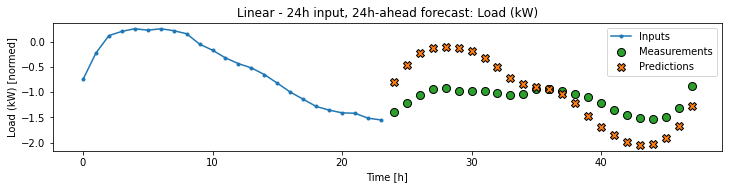

In [ ]:
%%time
multi_linear_model = tf.keras.Sequential([
    # Take the last time-step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

# history = compile_and_fit(multi_linear_model, multi_window)
history = compile_store_and_fit(multi_linear_model, multi_window, "Linear")

IPython.display.clear_output()
multi_val_performance['Linear'] = multi_linear_model.evaluate(multi_window.val)
multi_performance['Linear'] = multi_linear_model.evaluate(multi_window.test, verbose=0)
standardized_MAE, MAE, sMAPE, MAPE, MASE = \
    evaluate_denormed_all(multi_window.test, multi_window.test_df, multi_linear_model)
print("MAE: {}, Denormed MAE: {} sMAPE%: {}%, MAPE%: {}%, MASE: {}"
      .format(round(standardized_MAE, 2), round(MAE, 2), round(sMAPE, 2), round(MAPE, 2), round(MASE, 2)))
multi_window.plot(multi_linear_model, model_title="Linear -")

In [ ]:
multi_window.test
print(multi_linear_model.predict(multi_window.test).shape)

(3390, 24, 1)


#### Dense

Adding a `layers.Dense` between the input and output gives the linear model more power, but is still only based on a single input timestep.

214/214 [==============================] - 0s 2ms/step - loss: 0.1886 - mean_absolute_error: 0.3186
MAE: 0.16, Denormed MAE: 24815.36 sMAPE%: 2.2465828516%, MAPE%: 2.26%, MASE: 0.36
Wall time: 25.7 s


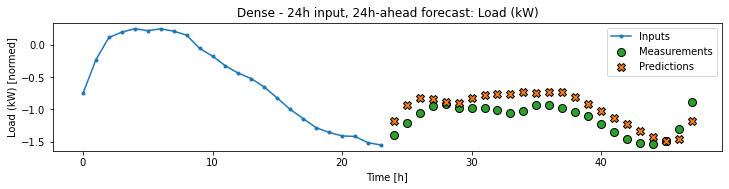

In [ ]:
%%time
multi_dense_model = tf.keras.Sequential([
    # Take the last time step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(512, activation='relu'),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

# history = compile_and_fit(multi_dense_model, multi_window)
history = compile_store_and_fit(multi_dense_model, multi_window, "Dense")
IPython.display.clear_output()
multi_val_performance['Dense'] = multi_dense_model.evaluate(multi_window.val)
multi_performance['Dense'] = multi_dense_model.evaluate(multi_window.test, verbose=0)
standardized_MAE, MAE, sMAPE, MAPE, MASE = \
    evaluate_denormed_all(multi_window.test, multi_window.test_df, multi_dense_model)
print("MAE: {}, Denormed MAE: {} sMAPE%: {}%, MAPE%: {}%, MASE: {}"
      .format(round(standardized_MAE, 2), round(MAE, 2), round(sMAPE, 10), round(MAPE, 2), round(MASE, 2)))
multi_window.plot(multi_dense_model, model_title="Dense -")

In [ ]:
%%time
std = train_std[0]
mean = train_mean[0]
def evaluate_denormed_MASE2(data, df, model, batch_size=32, forecast_horizon=24, m_interval=24):
    denormed_MASE = []
    x = df.shape[0]
    for batch_inputs, batch_labels in data.take(int(x/batch_size)):
        prediction = model.predict(batch_inputs)

        horizon_batches = batch_inputs.shape[0] * forecast_horizon

        denormed_prediction = (prediction * std) + mean
        denormed_expected = (batch_labels * std) + mean
        denormed_naive_m = (batch_inputs[:, :, 0:1] * std) + mean

        denormed_pre_MASE = (tf.abs(denormed_expected - denormed_prediction)
                             /(tf.abs(denormed_expected - denormed_naive_m)/m_interval))\
                            / horizon_batches
        denormed_MASE += denormed_pre_MASE.numpy().tolist()

    return np.array(denormed_MASE).mean()
MASE = evaluate_denormed_MASE2(multi_window.test, multi_window.test_df, multi_dense_model)
print("MASE: {}".format(round(MASE, 8)))

MASE: 0.36199735
Wall time: 2.96 s


In [ ]:
def denormed_mae(y_true, y_pred):
    denormed_mae = tf.metrics.MAE((y_true * train_std[0] + train_mean[0]), (y_pred * train_std[0] + train_mean[0]))
    return tf.reduce_mean(denormed_mae, axis=-1)

def denormed_mape(y_true, y_pred):
    denormed_mape = tf.metrics.MAPE((y_true * train_std[0] + train_mean[0]), (y_pred * train_std[0] + train_mean[0]))
    return tf.reduce_mean(denormed_mape, axis=-1)

def denormed_smape(y_true, y_pred):
    denormed_prediction = (y_pred * train_std[0]) + train_mean[0]
    denormed_expected = (y_true * train_std[0]) + train_mean[0]

    denormed_residuals = tf.abs(denormed_expected - denormed_prediction)
    denormed_denominator = tf.abs(denormed_expected) + tf.abs(denormed_prediction)
    denormed_pre_sMAPE = 200.0 * (denormed_residuals/denormed_denominator)
    return tf.reduce_mean(denormed_pre_sMAPE, axis=-1)

Tf metrics:

In [ ]:
%%time
multi_dense_model3 = tf.keras.Sequential([
    # Take the last time step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(512, activation='relu'),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

multi_dense_model3.compile(loss=tf.losses.MeanSquaredError(),
    optimizer=tf.optimizers.Adam(),
    metrics=[denormed_mae,
             denormed_mape,
             denormed_smape
             ])
z = multi_dense_model3.evaluate(multi_window.test)
MASE = evaluate_denormed_MASE2(multi_window.test, multi_window.test_df, multi_dense_model)
print("MASE: {}".format(round(MASE, 8)))
l = multi_dense_model3.metrics_names
for i in range(len(z)):
    print(round(z[i], 8), l[i])

106/106 [==============================] - 1s 2ms/step - loss: 0.7212 - denormed_mae: 112990.1484 - denormed_mape: 10.9238 - denormed_smape: 10.2024
MASE: 0.36199735
0.721183 loss
112990.1484375 denormed_mae
10.92384815 denormed_mape
10.20244789 denormed_smape
Wall time: 3.9 s


Loop metrics:

In [ ]:
%%time
multi_dense_model2 = tf.keras.Sequential([
    # Take the last time step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(512, activation='relu'),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

multi_dense_model2.compile(loss=tf.losses.MeanSquaredError(),
    optimizer=tf.optimizers.Adam(),
    metrics=[tf.metrics.MeanAbsoluteError()])

standardized_MAE, MAE, sMAPE, MAPE, MASE = \
    evaluate_denormed_all(multi_window.test, multi_window.test_df, multi_dense_model2)
print("MAE: {}, Denormed MAE: {} sMAPE%: {}%, MAPE%: {}%, MASE: {}"
      .format(round(standardized_MAE, 8), round(MAE, 8), round(sMAPE, 8), round(MAPE, 8), round(MASE, 8)))

MAE: 0.72751243, Denormed MAE: 112989.53574587 sMAPE%: 10.20207181%, MAPE%: 10.92311396%, MASE: 2.20380679
Wall time: 3.28 s


#### CNN

A convolutional model makes predictions based on a fixed-width history, which may lead to better performance than the dense model since it can see how things are changing over time:

![A convolutional model sees how things change over time](images/multistep_conv.png)

214/214 [==============================] - 0s 2ms/step - loss: 0.1435 - mean_absolute_error: 0.2740
MAE: 0.15, Denormed MAE: 22890.83 sMAPE%: 2.07%, MAPE%: 2.09%, MASE: 0.33
Wall time: 1min 42s


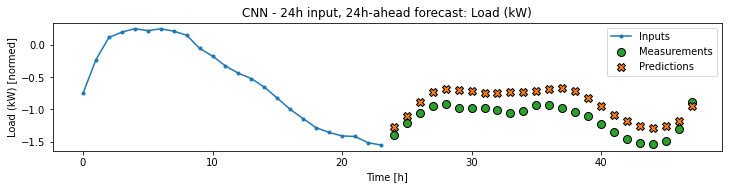

In [ ]:
%%time
CONV_WIDTH = 6
multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_store_and_fit(multi_conv_model, multi_window, "CNN")
IPython.display.clear_output()

multi_val_performance['Conv'] = multi_conv_model.evaluate(multi_window.val)
multi_performance['Conv'] = multi_conv_model.evaluate(multi_window.test, verbose=0)
standardized_MAE, MAE, sMAPE, MAPE, MASE = \
    evaluate_denormed_all(multi_window.test, multi_window.test_df, multi_conv_model)
print("MAE: {}, Denormed MAE: {} sMAPE%: {}%, MAPE%: {}%, MASE: {}"
      .format(round(standardized_MAE, 2), round(MAE, 2), round(sMAPE, 2), round(MAPE, 2), round(MASE, 2)))
multi_window.plot(multi_conv_model, model_title="CNN -")

#### RNN

A recurrent model can learn to use a long history of inputs, if it's relevant to the predictions the model is making. Here the model will accumulate internal state for 24h, before making a single prediction for the next 24h.

In this single-shot format, the LSTM only needs to produce an output at the last time step, so set `return_sequences=False`.

![The lstm accumulates state over the input window, and makes a single prediction for the next 24h](images/multistep_lstm.png)

## LSTM

214/214 [==============================] - 0s 2ms/step - loss: 0.1464 - mean_absolute_error: 0.2845
MAE: 0.17, Denormed MAE: 25845.29 sMAPE%: 2.36%, MAPE%: 2.37%, MASE: 0.31
Wall time: 1min 27s


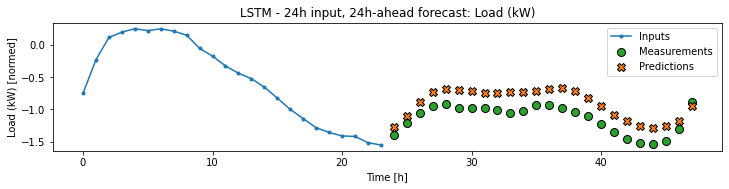

In [ ]:
%%time
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units]
    tf.keras.layers.LSTM(64, return_sequences=False, dropout=0.2),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_store_and_fit(multi_lstm_model, multi_window, "LSTM")

IPython.display.clear_output()
multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)
standardized_MAE, MAE, sMAPE, MAPE, MASE = \
    evaluate_denormed_all(multi_window.test, multi_window.test_df, multi_lstm_model)
print("MAE: {}, Denormed MAE: {} sMAPE%: {}%, MAPE%: {}%, MASE: {}"
      .format(round(standardized_MAE, 2), round(MAE, 2), round(sMAPE, 2), round(MAPE, 2), round(MASE, 2)))
multi_window.plot(multi_conv_model, model_title="LSTM -")

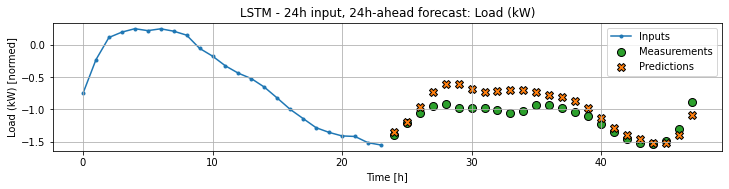

In [ ]:
fig_multi_window_lstm = multi_window.plot(multi_lstm_model, model_title="LSTM -")
# fig_multi_window_lstm.save
plt.grid(True)
plt.savefig('fig_multi_window_lstm.pdf', bbox_inches="tight", dpi=600)
plt.savefig('fig_multi_window_lstm.svg', bbox_inches="tight", dpi=600)
plt.savefig('fig_multi_window_lstm.png', bbox_inches="tight", dpi=600)

## GRU

214/214 [==============================] - 0s 2ms/step - loss: 0.1235 - mean_absolute_error: 0.2535
106/106 - 0s - loss: 0.0384 - mean_absolute_error: 0.1495
MAE: 0.15, Denormed MAE: 23221.81 sMAPE%: 2.12%, MAPE%: 2.13%, MASE: 0.28
Wall time: 1min 6s


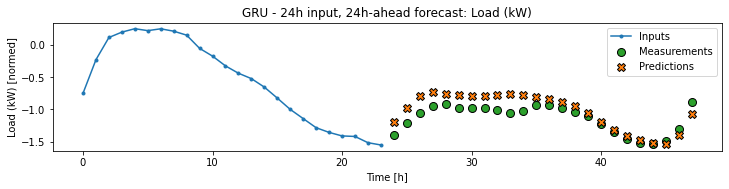

In [ ]:
%%time
multi_gru_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units]
    tf.keras.layers.GRU(64, return_sequences=False, dropout=0.2),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features, kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_store_and_fit(multi_gru_model, multi_window, "GRU")
IPython.display.clear_output()
multi_val_performance['GRU'] = multi_gru_model.evaluate(multi_window.val)
multi_performance['GRU'] = multi_gru_model.evaluate(multi_window.test, verbose=2)
standardized_MAE, MAE, sMAPE, MAPE, MASE = \
    evaluate_denormed_all(multi_window.test, multi_window.test_df, multi_gru_model)
print("MAE: {}, Denormed MAE: {} sMAPE%: {}%, MAPE%: {}%, MASE: {}"
      .format(round(standardized_MAE, 2), round(MAE, 2), round(sMAPE, 2), round(MAPE, 2), round(MASE, 2)))
multi_window.plot(multi_gru_model, model_title="GRU -")

### TODO: Quasi SVM (see: https://keras.io/examples/keras_recipes/quasi_svm/)

In [ ]:
# %%time
# from tensorflow import keras
# from tensorflow.keras import layers
# from tensorflow.keras.layers.experimental import RandomFourierFeatures
#
# multi_quasi_svm_model = tf.keras.Sequential([
#     # Shape [batch, time, features] => [batch, lstm_units]
#     # Adding more `gru_units` just overfits more quickly.
#     # tf.keras.layers.GRU(32, return_sequences=False),
#     # tf.keras.layers.GRU(64, return_sequences=False),
#     RandomFourierFeatures(
#             output_dim=4096, scale=10.0, kernel_initializer="gaussian"
#         ),
#     # Shape => [batch, out_steps*features]
#     tf.keras.layers.Dense(OUT_STEPS*num_features,
#                           kernel_initializer=tf.initializers.zeros),
#     # Shape => [batch, out_steps, features]
#     tf.keras.layers.Reshape([OUT_STEPS, num_features])
# ])
#
# history = compile_store_and_fit(multi_quasi_svm_model, multi_window, "GRU")
#
# IPython.display.clear_output()
#
# multi_val_performance['QuasiSVM'] = multi_quasi_svm_model.evaluate(multi_window.val)
# multi_performance['QuasiSVM'] = multi_quasi_svm_model.evaluate(multi_window.test, verbose=2)
# multi_window.plot(multi_quasi_svm_model, model_title="QuasiSVM -")

## TCN (see: https://github.com/philipperemy/keras-tcn)

In [ ]:
from tcn import TCN, tcn_full_summary

# The receptive field tells you how far the model can see in terms of timesteps.
tcn_layer = TCN(64, return_sequences=False)  # hour x 24 x 7
tcn_layer_receptive_field = tcn_layer.receptive_field

print("Receptive field size = \n\t{} hours, {} days, {} weeks, {} months"
      .format(tcn_layer_receptive_field,
              round(tcn_layer_receptive_field/24.0, 2),
              round(tcn_layer_receptive_field/(24.0 * 7.0), 2),
              round(tcn_layer_receptive_field/(24.0 * 30.0), 2)))

Receptive field size = 
	253 hours, 10.54 days, 1.51 weeks, 0.35 months


In [ ]:
%%time
multi_tcn_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units]
    TCN(64, return_sequences=False, dropout_rate=0.2, kernel_size=6),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features, kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_store_and_fit(multi_tcn_model, multi_window, "TCN")
IPython.display.clear_output()
multi_val_performance['TCN'] = multi_tcn_model.evaluate(multi_window.val)
multi_performance['TCN'] = multi_tcn_model.evaluate(multi_window.test, verbose=0)
standardized_MAE, MAE, sMAPE, MAPE, MASE = \
    evaluate_denormed_all(multi_window.test, multi_window.test_df, multi_tcn_model)
print("MAE: {}, Denormed MAE: {} sMAPE%: {}%, MAPE%: {}%, MASE: {}"
      .format(round(standardized_MAE, 2), round(MAE, 2), round(sMAPE, 2), round(MAPE, 2), round(MASE, 2)))
multi_window.plot(multi_tcn_model, model_title="TCN -", max_subplots=3)

751/751 [==============================] - 12s 13ms/step - loss: 0.1830 - mean_absolute_error: 0.3094 - val_loss: 0.1826 - val_mean_absolute_error: 0.3176
Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
tcn_1 (TCN)                  (None, 64)                285504    
_________________________________________________________________
dense_12 (Dense)             (None, 24)                1560      
_________________________________________________________________
reshape_7 (Reshape)          (None, 24, 1)             0         
Total params: 287,064
Trainable params: 287,064
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/150
751/751 [==============================] - 9s 12ms/step - loss: 0.0930 - mean_absolute_error: 0.2163 - val_loss: 0.1939 - val_mean_absolute_error: 0.3225
Epoch 2/150
751/751 [==============================]

KeyboardInterrupt: 

## LSTM Attention (see: https://github.com/philipperemy/keras-attention-mechanism)

In [ ]:
%%time
from attention import Attention
multi_lstm_attention_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True, dropout=0.2),
    Attention(32),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features, kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_store_and_fit(multi_lstm_attention_model, multi_window, "LSTM Attention")
IPython.display.clear_output()
multi_val_performance['LSTM Attention'] = multi_lstm_attention_model.evaluate(multi_window.val)
multi_performance['LSTM Attention'] = multi_lstm_attention_model.evaluate(multi_window.test, verbose=0)
standardized_MAE, MAE, sMAPE, MAPE, MASE = \
    evaluate_denormed_all(multi_window.test, multi_window.test_df, multi_lstm_attention_model)
print("MAE: {}, Denormed MAE: {} sMAPE%: {}%, MAPE%: {}%, MASE: {}"
      .format(round(standardized_MAE, 2), round(MAE, 2), round(sMAPE, 2), round(MAPE, 2), round(MASE, 2)))
multi_window.plot(multi_lstm_attention_model, model_title="LSTM Attention -")

KeyboardInterrupt: 

In [ ]:
multi_lstm_attention_model.evaluate(multi_window.test, verbose=0)[1]

KeyboardInterrupt: 

## TODO: BNN (see: https://keras.io/examples/keras_recipes/bayesian_neural_networks/)

## TFP

In [ ]:
# import tensorflow_probability as tfp
# tfd = tfp.distributions
#
# NUM_TRAIN_EXAMPLES = train_df.shape[0]
# kl_divergence_function = (lambda q, p, _: tfd.kl_divergence(q, p) /  # pylint: disable=g-long-lambda
#                         tf.cast(NUM_TRAIN_EXAMPLES, dtype=tf.float32))
#
# multi_flipout_model = tf.keras.Sequential([
#     # Take the last time-step.
#     # Shape [batch, time, features] => [batch, 1, features]
#     tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
#     # Shape => [batch, 1, out_steps*features]
#     # tf.keras.layers.Dense(OUT_STEPS*num_features, kernel_initializer=tf.initializers.zeros),
#     # tfp.layers.DenseFlipout(OUT_STEPS*num_features),
#     # tf.keras.layers.BatchNormalization(),
#     tfp.layers.DenseFlipout(OUT_STEPS*num_features,
#             kernel_divergence_fn=kl_divergence_function,
#           activation=tf.nn.relu),
#   # tfp.layers.DistributionLambda(
#   #     lambda t: tfd.Normal(loc=t[..., :1],
#   #                          scale=1e-3 + tf.math.softplus(0.05 * t[...,1:]))),
#     # Shape => [batch, out_steps, features]
#     tf.keras.layers.Reshape([OUT_STEPS, num_features])
# ])
#
# # multi_gru_model = tf.keras.Sequential([
# #     # Shape [batch, time, features] => [batch, lstm_units]
# #     # Adding more `gru_units` just overfits more quickly.
# #     tf.keras.layers.GRU(32, return_sequences=False),
# #     # Shape => [batch, out_steps*features]
# #     tf.keras.layers.Dense(OUT_STEPS*num_features,
# #                           kernel_initializer=tf.initializers.zeros),
# #     # Shape => [batch, out_steps, features]
# #     tf.keras.layers.Reshape([OUT_STEPS, num_features])
# # ])
#
# history = compile_and_fit(multi_flipout_model, multi_window)
#
# IPython.display.clear_output()
#
# multi_val_performance['Flipout'] = multi_flipout_model.evaluate(multi_window.val)
# multi_performance['Flipout'] = multi_flipout_model.evaluate(multi_window.test, verbose=2)
# multi_window.plot(multi_flipout_model, model_title="Flipout -")

### Performance

There are clearly diminishing returns as a function of model complexity on this problem.

In [ ]:
x = np.arange(len(multi_performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = multi_lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in multi_val_performance.values()]
test_mae = [v[metric_index] for v in multi_performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()

The metrics for the multi-output models in the first half of this tutorial show the performance averaged across all output features. These performances similar but also averaged across output timesteps.

In [ ]:
for name, value in multi_performance.items():
  print(f'{name:8s}: {value[1]:0.4f}')

In [ ]:
print("Manual Baseline MAE\n")

normed_mae_4d = np.mean(np.abs(test_df["Load (kW)"] - test_df['Load (kW)'].shift(24*4)))
normed_mae_5d = np.mean(np.abs(test_df["Load (kW)"] - test_df['Load (kW)'].shift(24*5)))
normed_mae_6d = np.mean(np.abs(test_df["Load (kW)"] - test_df['Load (kW)'].shift(24*6)))
normed_mae_7d = np.mean(np.abs(test_df["Load (kW)"] - test_df['Load (kW)'].shift(24*7)))
normed_mae_8d = np.mean(np.abs(test_df["Load (kW)"] - test_df['Load (kW)'].shift(24*8)))
normed_mae_9d = np.mean(np.abs(test_df["Load (kW)"] - test_df['Load (kW)'].shift(24*9)))
print(f"Test MAE 4d24h: {normed_mae_4d:0.4f}")
print(f"Test MAE 5d24h: {normed_mae_5d:0.4f}")
print(f"Test MAE 6d24h: {normed_mae_6d:0.4f}")
print(f"Test MAE 7d24h: {normed_mae_7d:0.4f}")
print(f"Test MAE 8d24h: {normed_mae_8d:0.4f}")
print(f"Test MAE 9d24h: {normed_mae_9d:0.4f}")

## Fixed model runs

In [ ]:
run_count = 1 # 100 # 1
model_performances = pd.DataFrame(columns=["timestamp", "run", "model", "val_MAE", "MAE", "denormalized_MAE",
                                           "denormalized_MASE", "denormalized_MAPE", "denormalized_sMAPE", "type"])

In [ ]:
%%time
import time
from datetime import datetime

models = [
    ("Last1h", last_baseline),
    ("Repeat24h", repeat_baseline),
    ("Repeat7d24h", repeat_7d24h_baseline),
    ("Linear", multi_linear_model),
    ("Dense", multi_dense_model),
    ("CNN", multi_conv_model),
    ("LSTM", multi_lstm_model),
    ("GRU", multi_gru_model),
    ("TCN", multi_tcn_model),
    ("LSTM Attention", multi_lstm_attention_model),
]

seed = 0
for i in range(run_count):
    seed += 1
    tf.random.set_seed(seed)
    for model_name, model_instance in models:
        delete_model(model_instance)
        if model_name == "Linear":
            model_instance = tf.keras.Sequential([
                tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
                tf.keras.layers.Dense(OUT_STEPS*num_features, kernel_initializer=tf.initializers.zeros),
                tf.keras.layers.Reshape([OUT_STEPS, num_features])
            ])
        elif model_name == "Dense":
            model_instance = tf.keras.Sequential([
                tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
                tf.keras.layers.Dense(512, activation='relu'),
                tf.keras.layers.Dense(OUT_STEPS*num_features, kernel_initializer=tf.initializers.zeros),
                tf.keras.layers.Reshape([OUT_STEPS, num_features])
            ])
        elif model_name == "CNN":
            CONV_WIDTH = 6
            model_instance = tf.keras.Sequential([
                tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
                tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
                tf.keras.layers.Dense(OUT_STEPS*num_features, kernel_initializer=tf.initializers.zeros),
                tf.keras.layers.Reshape([OUT_STEPS, num_features])
            ])
        elif model_name == "LSTM":
            model_instance = tf.keras.Sequential([
                tf.keras.layers.LSTM(64, return_sequences=False, dropout=0.2),
                tf.keras.layers.Dense(OUT_STEPS*num_features, kernel_initializer=tf.initializers.zeros),
                tf.keras.layers.Reshape([OUT_STEPS, num_features])
            ])
        elif model_name == "GRU":
            model_instance = tf.keras.Sequential([
                # tf.keras.layers.GRU(32, return_sequences=False),
                tf.keras.layers.GRU(64, return_sequences=False, dropout=0.2),
                tf.keras.layers.Dense(OUT_STEPS*num_features, kernel_initializer=tf.initializers.zeros),
                tf.keras.layers.Reshape([OUT_STEPS, num_features])
            ])
        elif model_name == "TCN":
            model_instance = tf.keras.Sequential([
                TCN(64, return_sequences=False, dropout_rate=0.2, kernel_size=6),
                tf.keras.layers.Dense(OUT_STEPS*num_features, kernel_initializer=tf.initializers.zeros),
                tf.keras.layers.Reshape([OUT_STEPS, num_features])
            ])
        elif model_name == "LSTM Attention":
            model_instance = tf.keras.Sequential([
                tf.keras.layers.LSTM(32, return_sequences=True),
                Attention(32),
                tf.keras.layers.Dense(OUT_STEPS*num_features, kernel_initializer=tf.initializers.zeros),
                tf.keras.layers.Reshape([OUT_STEPS, num_features])
            ])

        compile_and_fit(model_instance, multi_window, verbosity=0)
        standardized_MAE, MAE, sMAPE, MAPE, MASE = evaluate_denormed_all(
            multi_window.test, multi_window.test_df, model_instance)
        new_row = {"timestamp": str(int(time.time())), "run": i, "model": model_name,
            "val_MAE": model_instance.evaluate(multi_window.val, verbose=0)[1],
            "MAE": model_instance.evaluate(multi_window.test, verbose=0)[1],
            "denormalized_MAE": MAE,
            "denormalized_MASE": MASE,
            "denormalized_MAPE": MAPE,
            "denormalized_sMAPE": sMAPE,
            "type": model_type}
        print(new_row)
        model_performances = model_performances.append(new_row, ignore_index=True)

now = datetime.now() # current date and time
datetime_str = now.strftime("%m-%d-%Y_%H_%M_%S")
model_performances.to_csv("logs/model_performances_LSTM_GRU_TCN_attention_{}_runs{}{}_{}.csv"
                          .format(model_type, run_count, ablation_text, datetime_str))

In [ ]:
# Set figure size
sns.set( rc = {'figure.figsize' : ( 20, 20 ), 'axes.labelsize' : 12 })
sns.set_theme(style="whitegrid")
g = sns.catplot(x="model", y="MAE",
                hue="type",
                col="type",
                data=model_performances, kind="box",
                # height=4,
                # aspect=.7
                linewidth=1
                )
g.fig.suptitle("24h-ahead accuracy: DR-DNN vs DNN (train/val: 2017-20, test: 2020-21, runs: {})".format(run_count) ,
               fontsize = 'x-large' ,
               fontweight = 'bold' )
g.fig.subplots_adjust( top = 0.85 )
g.set_axis_labels( "Model" , "Mean Absolute Error (MAE)", fontsize=16)
g.set_xticklabels(rotation=90, fontsize=16)

plt.show()

In [ ]:
# Set figure size
sns.set( rc = {'figure.figsize' : ( 20, 20 ), 'axes.labelsize' : 12 })
sns.set_theme(style="whitegrid")
g = sns.catplot(x="model", y="denormalized_MAE",
                hue="type",
                col="type",
                data=model_performances, kind="box",
                # height=4,
                # aspect=.7
                linewidth=1
                )
g.fig.suptitle("24h-ahead accuracy: DR-DNN vs DNN (train/val: 2017-20, test: 2020-21, runs: {})".format(run_count) ,
               fontsize = 'x-large' ,
               fontweight = 'bold' )
g.fig.subplots_adjust( top = 0.85 )
g.set_axis_labels( "Model" , "Load (kW) Mean Absolute Error (MAE)", fontsize=16)
g.set_xticklabels(rotation=90, fontsize=16)

plt.show()

# Keras tuner

In [ ]:
max_trials = 20 # 2 # 20 # 50  # BO Hyperopt max iterations
hyperopt_runs = 1 # 1 # 10  # Number of times to repeat the hyperparameter search
hyperopt_max_epochs = 300 # 300 # 500 # 350 # 5 # 50 # DNN model iterations
min_units = 8 # 8 # 64
max_units = 64 # 64 # 512
units_step = 8

In [ ]:
def compile_and_fit_custom(model, window, patience=stop_early_patience, verbosity=1,
                           custom_learning_rate=-1, custom_max_epochs=MAX_EPOCHS,
                           min_learning_rate=min_learning_rate_on_plateau,
                           learning_rate_patience=reduce_learning_rate_patience):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, mode='min',
                                                      restore_best_weights=True, verbose=verbosity)
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=learning_rate_patience,
                                                     min_lr=min_learning_rate, verbose=verbosity)

    # model = reset_model_weights(model)
    if custom_learning_rate != -1:
        model.compile(loss=tf.losses.MeanSquaredError(),
        optimizer=tf.keras.optimizers.Adam(learning_rate=custom_learning_rate),
        metrics=[tf.metrics.MeanAbsoluteError()])
    else:
        model.compile(loss=tf.losses.MeanSquaredError(),
                      optimizer=tf.optimizers.Adam(),
                      metrics=[tf.metrics.MeanAbsoluteError()])
    history = model.fit(window.train, epochs=custom_max_epochs, validation_data=window.val,
                        callbacks=[early_stopping, reduce_lr], verbose=verbosity)
    return history


## BO TCN

In [ ]:
from kerastuner import RandomSearch, Hyperband, BayesianOptimization
from datetime import datetime
import time

max_layers = 1
stop_early_patience = 8
min_kernel_size = 1
max_kernel_size = 24
kernel_size_step = 1
min_nb_stacks = 1
max_nb_stacks = 3
nb_stacks_step = 1
main_model_name = "TCN"

def build_model(hp):

    i = 0
    # Model: TCN
    model = tf.keras.Sequential()
    model.add(TCN(hp.Int("units_" + str(i), min_value=min_units, max_value=max_units, step=units_step),
                  kernel_size=hp.Int("kernel_size", min_value=min_kernel_size, max_value=max_kernel_size, step=kernel_size_step),
                  #nb_stacks=hp.Int("nb_stacks", min_value=min_nb_stacks, max_value=max_nb_stacks, step=nb_stacks_step),
                  dropout_rate=hp.Choice("dropout_rate", values=[0.0, 0.01, 0.1, 0.2, 0.25, 0.35, 0.45, 0.5])
                  ))
    model.add(tf.keras.layers.Dense(OUT_STEPS*num_features, kernel_initializer=tf.initializers.zeros))
    model.add(tf.keras.layers.Reshape([OUT_STEPS, num_features]))

    optimizer_choice = hp.Choice("optimizer", values=["adam", "amsgrad", "nadam", "adagrad", "adadelta"])
    learning_rate_choice = hp.Choice("learning_rate", values=[1e-1, 1e-2, 1e-3, 1e-4])
    current_optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate_choice)
    if optimizer_choice == "adam":
        current_optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate_choice, amsgrad=False)
    elif optimizer_choice == "amsgrad":
        current_optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate_choice, amsgrad=True)
    elif optimizer_choice == "nadam":
        current_optimizer = tf.keras.optimizers.Nadam(learning_rate=learning_rate_choice)
    elif optimizer_choice == "adagrad":
        current_optimizer = tf.keras.optimizers.Adagrad(learning_rate=learning_rate_choice)
    elif optimizer_choice == "adadelta":
        current_optimizer = tf.keras.optimizers.Adadelta(learning_rate=learning_rate_choice)
    model.compile(loss=tf.losses.MeanSquaredError(),
        optimizer=current_optimizer,
        metrics=[tf.metrics.MeanAbsoluteError()])
    return model

rows = []
model_hyperopt_performances = pd.DataFrame(columns=["timestamp", "run", "model", "val_MAE", "MAE", "denormalized_MAE", "denormalized_MASE", "denormalized_MAPE", "denormalized_sMAPE", "type", "best_hyperparams"])

for i in range(hyperopt_runs):
    # BayesianOptimization  options, see: https://keras.io/api/keras_tuner/tuners/bayesian/
    tuner = BayesianOptimization (
        build_model,
        objective="val_loss",
        # factor=3,  # Integer, the reduction factor for the number of epochs and number of models for each bracket. Defaults to 3.
        max_trials=max_trials,  # Integer, the total number of trials (model configurations) to test at most. Note that the oracle may interrupt the search before max_trial models have been tested if the search space has been exhausted.
        seed=seed,  #  Optional integer, the random seed.
        overwrite=True,
        num_initial_points=3, # Optional number of randomly generated samples as initial training data for Bayesian optimization. If left unspecified, a value of 3 times the dimensionality of the hyperparameter space is used.
        alpha=1e-4, # Float, the value added to the diagonal of the kernel matrix during fitting. It represents the expected amount of noise in the observed performances in Bayesian optimization. Defaults to 1e-4.
        beta=2.6, # Float, the balancing factor of exploration and exploitation. The larger it is, the more explorative it is. Defaults to 2.6.
        directory="keras_tuner_hyperopt",
        project_name=f"{model_type}_hyperopt",
    )

    tuner.search_space_summary()

    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=stop_early_patience, restore_best_weights=True, mode='min', verbose=1)
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=reduce_learning_rate_patience, min_lr=min_learning_rate_on_plateau, verbose=1)
        # tuner.search(multi_window.train, epochs=MAX_EPOCHS, validation_data=multi_window.val, callbacks=[early_stopping])
    tuner.search(multi_window.train, epochs=hyperopt_max_epochs, validation_data=multi_window.val, callbacks=[early_stopping, reduce_lr])

    best_model = tuner.get_best_models()[0]
    best_hp = tuner.get_best_hyperparameters()[0]

    tuner.results_summary()
    hyperopt_model_name = "{}_epochs{}_units{}_{}".format(main_model_name, hyperopt_max_epochs, min_units, max_units)
    standardized_MAE, MAE, sMAPE, MAPE, MASE = evaluate_denormed_all(multi_window.test, multi_window.test_df, best_model)
    new_row = {"timestamp": str(int(time.time())), "run": i, "model": hyperopt_model_name,
        "val_MAE": best_model.evaluate(multi_window.val, verbose=0)[1],
        "MAE": best_model.evaluate(multi_window.test, verbose=0)[1],
        "denormalized_MAE": MAE,
        "denormalized_MASE": MASE,
        "denormalized_MAPE": MAPE,
        "denormalized_sMAPE": sMAPE,
        "type": model_type,
        "best_hyperparams": { "units": best_hp.values["units_0"], "optimizer": best_hp.values["optimizer"], "learning_rate": best_hp.values["learning_rate"], "dropout": best_hp.values["dropout_rate"], "kernel_size": best_hp.values["kernel_size"] }}
    print(new_row)
    model_hyperopt_performances = model_hyperopt_performances.append(new_row, ignore_index=True)

now = datetime.now() # current date and time
datetime_str = now.strftime("%m-%d-%Y_%H_%M_%S")
model_hyperopt_performances.to_csv("logs/BO_{}_{}_runs{}_{}.csv".format(hyperopt_model_name, model_type, hyperopt_runs, datetime_str))

In [ ]:
now = datetime.now() # current date and time
datetime_str = now.strftime("%m-%d-%Y_%H_%M_%S")
model_hyperopt_performances.to_csv("logs/BO_{}_{}_runs{}_{}.csv".format(hyperopt_model_name, model_type, hyperopt_runs, datetime_str))

## BO GRU

In [ ]:
from kerastuner import RandomSearch, Hyperband, BayesianOptimization
from datetime import datetime
import time

max_layers = 1
stop_early_patience = 8
main_model_name = "GRU"

def build_model(hp):

    i = 0
    # Model: GRU
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.GRU(units=hp.Int("units_" + str(i), min_value=min_units, max_value=max_units, step=units_step),
                  dropout=hp.Choice("dropout", values=[0.0, 0.01, 0.1, 0.2, 0.25, 0.35, 0.45, 0.5]),
                    #recurrent_dropout=hp.Choice("recurrent_dropout", values=[0.0, 0.01, 0.1, 0.2, 0.25, 0.35, 0.45, 0.5])
    ))
    model.add(tf.keras.layers.Dense(OUT_STEPS*num_features, kernel_initializer=tf.initializers.zeros))
    model.add(tf.keras.layers.Reshape([OUT_STEPS, num_features]))

    optimizer_choice = hp.Choice("optimizer", values=["adam", "amsgrad", "nadam", "adagrad", "adadelta"])
    learning_rate_choice = hp.Choice("learning_rate", values=[1e-1, 1e-2, 1e-3, 1e-4])
    current_optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate_choice)
    if optimizer_choice == "adam":
        current_optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate_choice, amsgrad=False)
    elif optimizer_choice == "amsgrad":
        current_optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate_choice, amsgrad=True)
    elif optimizer_choice == "nadam":
        current_optimizer = tf.keras.optimizers.Nadam(learning_rate=learning_rate_choice)
    elif optimizer_choice == "adagrad":
        current_optimizer = tf.keras.optimizers.Adagrad(learning_rate=learning_rate_choice)
    elif optimizer_choice == "adadelta":
        current_optimizer = tf.keras.optimizers.Adadelta(learning_rate=learning_rate_choice)
    model.compile(loss=tf.losses.MeanSquaredError(),
        optimizer=current_optimizer,
        metrics=[tf.metrics.MeanAbsoluteError()])
    return model

rows = []
model_hyperopt_performances = pd.DataFrame(columns=["timestamp", "run", "model", "val_MAE", "MAE", "denormalized_MAE", "denormalized_MASE", "denormalized_MAPE", "denormalized_sMAPE", "type", "best_hyperparams"])
for i in range(hyperopt_runs):
    # BayesianOptimization  options, see: https://keras.io/api/keras_tuner/tuners/bayesian/
    tuner = BayesianOptimization (
        build_model,
        objective="val_loss",
        # factor=3,  # Integer, the reduction factor for the number of epochs and number of models for each bracket. Defaults to 3.
        max_trials=max_trials,  # Integer, the total number of trials (model configurations) to test at most. Note that the oracle may interrupt the search before max_trial models have been tested if the search space has been exhausted.
        seed=seed,  #  Optional integer, the random seed.
        overwrite=True,
        num_initial_points=3, # Optional number of randomly generated samples as initial training data for Bayesian optimization. If left unspecified, a value of 3 times the dimensionality of the hyperparameter space is used.
        alpha=1e-4, # Float, the value added to the diagonal of the kernel matrix during fitting. It represents the expected amount of noise in the observed performances in Bayesian optimization. Defaults to 1e-4.
        beta=2.6, # Float, the balancing factor of exploration and exploitation. The larger it is, the more explorative it is. Defaults to 2.6.
        directory="keras_tuner_hyperopt",
        project_name=f"{model_type}_hyperopt",
    )

    tuner.search_space_summary()

    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=stop_early_patience, restore_best_weights=True, mode='min', verbose=1)
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=reduce_learning_rate_patience, min_lr=min_learning_rate_on_plateau, verbose=1)
        # tuner.search(multi_window.train, epochs=MAX_EPOCHS, validation_data=multi_window.val, callbacks=[early_stopping])
    tuner.search(multi_window.train, epochs=hyperopt_max_epochs, validation_data=multi_window.val, callbacks=[early_stopping, reduce_lr])

    # models = tuner.get_best_models(num_models=2)
    best_model = tuner.get_best_models()[0]
    best_hp = tuner.get_best_hyperparameters()[0]

    tuner.results_summary()
    hyperopt_model_name = "{}_epochs{}_units{}_{}".format(main_model_name, hyperopt_max_epochs, min_units, max_units)
    standardized_MAE, MAE, sMAPE, MAPE, MASE = evaluate_denormed_all(multi_window.test, multi_window.test_df, best_model)
    new_row = {"timestamp": str(int(time.time())), "run": i, "model": hyperopt_model_name,
        "val_MAE": best_model.evaluate(multi_window.val, verbose=0)[1],
        "MAE": best_model.evaluate(multi_window.test, verbose=0)[1],
        "denormalized_MAE": MAE,
        "denormalized_MASE": MASE,
        "denormalized_MAPE": MAPE,
        "denormalized_sMAPE": sMAPE,
        "type": model_type,
        "best_hyperparams": { "units": best_hp.values["units_0"], "optimizer": best_hp.values["optimizer"], "learning_rate": best_hp.values["learning_rate"], "dropout": best_hp.values["dropout"] }}
    print(new_row)
    model_hyperopt_performances = model_hyperopt_performances.append(new_row, ignore_index=True)

now = datetime.now() # current date and time
datetime_str = now.strftime("%m-%d-%Y_%H_%M_%S")
model_hyperopt_performances.to_csv("logs/BO_{}_{}_runs{}_{}.csv".format(hyperopt_model_name, model_type, hyperopt_runs, datetime_str))

## BO LSTM Attention

In [ ]:
from kerastuner import RandomSearch, Hyperband, BayesianOptimization
from datetime import datetime
import time

max_layers = 1
stop_early_patience = 8
main_model_name = "LSTM_Attention"

def build_model(hp):

    i = 0
    # Model: LSTM Attention
    current_units = int(round(hp.Int("units_" + str(i), min_value=min_units, max_value=max_units, step=units_step)/2.0, 0))
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.LSTM(units=current_units, return_sequences=True,
                  dropout=hp.Choice("dropout", values=[0.0, 0.01, 0.1, 0.2, 0.25, 0.35, 0.45, 0.5]),
                    #recurrent_dropout=hp.Choice("recurrent_dropout", values=[0.0, 0.01, 0.1, 0.2, 0.25, 0.35, 0.45, 0.5])
                                   ))
    model.add(Attention(current_units))
    model.add(tf.keras.layers.Dense(OUT_STEPS*num_features, kernel_initializer=tf.initializers.zeros))
    model.add(tf.keras.layers.Reshape([OUT_STEPS, num_features]))

    optimizer_choice = hp.Choice("optimizer", values=["adam", "amsgrad", "nadam", "adagrad", "adadelta"])
    learning_rate_choice = hp.Choice("learning_rate", values=[1e-1, 1e-2, 1e-3, 1e-4])
    current_optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate_choice)
    if optimizer_choice == "adam":
        current_optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate_choice, amsgrad=False)
    elif optimizer_choice == "amsgrad":
        current_optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate_choice, amsgrad=True)
    elif optimizer_choice == "nadam":
        current_optimizer = tf.keras.optimizers.Nadam(learning_rate=learning_rate_choice)
    elif optimizer_choice == "adagrad":
        current_optimizer = tf.keras.optimizers.Adagrad(learning_rate=learning_rate_choice)
    elif optimizer_choice == "adadelta":
        current_optimizer = tf.keras.optimizers.Adadelta(learning_rate=learning_rate_choice)
    model.compile(loss=tf.losses.MeanSquaredError(),
        optimizer=current_optimizer,
        metrics=[tf.metrics.MeanAbsoluteError()])
    return model

rows = []
model_hyperopt_performances = pd.DataFrame(columns=["timestamp", "run", "model", "val_MAE", "MAE", "denormalized_MAE", "denormalized_MASE", "denormalized_MAPE", "denormalized_sMAPE", "type", "best_hyperparams"])
for i in range(hyperopt_runs):
    # BayesianOptimization  options, see: https://keras.io/api/keras_tuner/tuners/bayesian/
    tuner = BayesianOptimization (
        build_model,
        objective="val_loss",
        # factor=3,  # Integer, the reduction factor for the number of epochs and number of models for each bracket. Defaults to 3.
        max_trials=max_trials,  # Integer, the total number of trials (model configurations) to test at most. Note that the oracle may interrupt the search before max_trial models have been tested if the search space has been exhausted.
        seed=seed,  #  Optional integer, the random seed.
        overwrite=True,
        num_initial_points=3, # Optional number of randomly generated samples as initial training data for Bayesian optimization. If left unspecified, a value of 3 times the dimensionality of the hyperparameter space is used.
        alpha=1e-4, # Float, the value added to the diagonal of the kernel matrix during fitting. It represents the expected amount of noise in the observed performances in Bayesian optimization. Defaults to 1e-4.
        beta=2.6, # Float, the balancing factor of exploration and exploitation. The larger it is, the more explorative it is. Defaults to 2.6.
        directory="keras_tuner_hyperopt",
        project_name=f"{model_type}_hyperopt",
    )

    tuner.search_space_summary()

    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=stop_early_patience, restore_best_weights=True, mode='min', verbose=1)
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=reduce_learning_rate_patience, min_lr=min_learning_rate_on_plateau, verbose=1)
    # tuner.search(multi_window.train, epochs=MAX_EPOCHS, validation_data=multi_window.val, callbacks=[early_stopping])
    tuner.search(multi_window.train, epochs=hyperopt_max_epochs, validation_data=multi_window.val, callbacks=[early_stopping, reduce_lr])

    best_hp = tuner.get_best_hyperparameters()[0]

    tuner.results_summary()

    current_units = int(round(best_hp.values["units_0"]/2.0, 0))
    best_model = tf.keras.Sequential([
                    tf.keras.layers.LSTM(current_units, return_sequences=True, dropout=best_hp.values["dropout"]),
                    Attention(current_units),
                    tf.keras.layers.Dense(OUT_STEPS*num_features, kernel_initializer=tf.initializers.zeros),
                    tf.keras.layers.Reshape([OUT_STEPS, num_features])
                ])

    compile_and_fit_custom(best_model, multi_window, verbosity=0, custom_learning_rate=best_hp.values["learning_rate"], custom_max_epochs=hyperopt_max_epochs)

    hyperopt_model_name = "{}_epochs{}_units{}_{}".format(main_model_name, hyperopt_max_epochs, min_units, max_units)
    standardized_MAE, MAE, sMAPE, MAPE, MASE = evaluate_denormed_all(multi_window.test, multi_window.test_df, best_model)
    new_row = {"timestamp": str(int(time.time())), "run": i, "model": hyperopt_model_name,
        "val_MAE": best_model.evaluate(multi_window.val, verbose=0)[1],
        "MAE": best_model.evaluate(multi_window.test, verbose=0)[1],
        "denormalized_MAE": MAE,
        "denormalized_MASE": MASE,
        "denormalized_MAPE": MAPE,
        "denormalized_sMAPE": sMAPE,
        "type": model_type,
        "best_hyperparams": { "units": int(round(best_hp.values["units_0"]/2.0, 0)), "optimizer": best_hp.values["optimizer"], "learning_rate": best_hp.values["learning_rate"], "dropout": best_hp.values["dropout"] }}
    print(new_row)
    model_hyperopt_performances = model_hyperopt_performances.append(new_row, ignore_index=True)
now = datetime.now() # current date and time
datetime_str = now.strftime("%m-%d-%Y_%H_%M_%S")
model_hyperopt_performances.to_csv("logs/BO_{}_{}_runs{}_{}.csv".format(hyperopt_model_name, model_type, hyperopt_runs, datetime_str))

## Statistical tests

Welch's t-test of unequal variances:

In [ ]:
from scipy import stats
import pandas as pd
# Read CSV data:
# no_dr_model_runs = pd.read_csv("logs/model_performances_LSTM_GRU_TCN_attention_No DR_runs100_11-19-2021_15_03_55.csv")
# dr_dnn_model_runs = pd.read_csv("logs/model_performances_LSTM_GRU_TCN_attention_DR-DNN_runs100_11-18-2021_04_27_01.csv")

no_dr_model_runs = pd.read_csv("logs/model_performances_LSTM_GRU_TCN_attention_No DR_runs100_12-04-2021_14_19_16.csv")
dr_dnn_model_runs = pd.read_csv("logs/model_performances_LSTM_GRU_TCN_attention_DR-DNN_runs100_12-05-2021_18_19_05.csv")  # DR-DNN without moving filters (EMA, moving variance, moving sum)
# dr_dnn_model_runs = pd.read_csv("logs/model_performances_LSTM_GRU_TCN_attention_DR-DNN_runs100_12-20-2021_15_04_09.csv")  # Full DR-DNN

print("Welch's t test:\n")
for model_metric in ["denormalized_MAE", "denormalized_MASE", "denormalized_MAPE", "denormalized_sMAPE"]:
    print("\n{}:".format(model_metric))
    for model_subtype in ["Linear", "Dense", "CNN", "LSTM", "GRU", "TCN", "LSTM Attention"]:
        k1 = dr_dnn_model_runs.loc[dr_dnn_model_runs.model == model_subtype][model_metric]
        k2 = no_dr_model_runs.loc[no_dr_model_runs.model == model_subtype][model_metric]
        l = stats.ttest_ind(k1, k2, equal_var=False) # alternative: { "two-sided", "less", "greater"}
        bool_pass = True if l.statistic < 0.0 else False
        print("{} - pass? {} statistic: {}, p-value: {} (DR-DNN mean: {}, No DR mean: {})".format(model_subtype, bool_pass, round(l.statistic, 4), l.pvalue, round(k1.mean(), 2), round(k2.mean(), 2)))

## Training times

In [ ]:
# no_dr_model_runs = pd.read_csv("logs/model_performances_LSTM_GRU_TCN_attention_No DR_runs100_11-19-2021_15_03_55.csv")
# dr_dnn_model_runs = pd.read_csv("logs/model_performances_LSTM_GRU_TCN_attention_DR-DNN_runs100_11-18-2021_04_27_01.csv")
no_dr_model_runs = pd.read_csv("logs/model_performances_LSTM_GRU_TCN_attention_No DR_runs100_12-04-2021_14_19_16.csv")
dr_dnn_model_runs = pd.read_csv("logs/model_performances_LSTM_GRU_TCN_attention_DR-DNN_runs100_12-05-2021_18_19_05.csv")  # DR-DNN without moving filters (EMA, moving variance, moving sum)
# dr_dnn_model_runs = pd.read_csv("logs/model_performances_LSTM_GRU_TCN_attention_DR-DNN_runs100_12-20-2021_15_04_09.csv")  # Full DR-DNN
dr_layer_time = 20 # seconds

no_dr_model_runs["duration"] =  no_dr_model_runs["timestamp"].diff()
dr_dnn_model_runs["duration"] =  dr_dnn_model_runs["timestamp"].diff()

print("Model training times:\n")
for model_subtype in ["Linear", "Dense", "CNN", "LSTM", "GRU", "TCN", "LSTM Attention"]:
    print("\n{}:".format(model_subtype))
    dr_dnn_model_times = dr_dnn_model_runs.loc[dr_dnn_model_runs.model == model_subtype]["duration"]
    no_dr_model_times = no_dr_model_runs.loc[no_dr_model_runs.model == model_subtype]["duration"]
    print("Training time increase: {}x - DR-DNN: {} +/- {} vs No DR: {} +/- {}"
          .format(round(dr_dnn_model_times.mean()/no_dr_model_times.mean(), 1), round(dr_dnn_model_times.mean(), 4),
                  round(dr_dnn_model_times.std(), 3), round(no_dr_model_times.mean(), 3), round(no_dr_model_times.std(), 3)))
    print("Training time increase (with DR layer): {}x - DR-DNN: DR layer = {} secs + {} +/- {} vs No DR: {} +/- {}"
              .format(round((dr_dnn_model_times.mean() + dr_layer_time)/no_dr_model_times.mean(), 1), dr_layer_time, round(dr_dnn_model_times.mean(), 4),
                      round(dr_dnn_model_times.std(), 3), round(no_dr_model_times.mean(), 3), round(no_dr_model_times.std(), 3)))

### Latex table of results (all metrics + statistical test)

In [ ]:
to_print = []

digits_round = { "denormalized_MAE": 0, "denormalized_MAPE": 3, "denormalized_sMAPE": 3, "denormalized_MASE": 3, "duration": 1 }
print("\\begin{tabular}{ l l | l | l | l | l | l}")
print("\\textbf{Model} & & \\textbf{MAE} & \\textbf{MAPE} & \\textbf{sMAPE} & \\textbf{MASE} & \\textbf{Training time}\\\\")
print(" & & (kW) & (\%) & (\%) & & (seconds)\\\\")
print("\\hline")

for model_subtype in ["Linear", "Dense", "LSTM", "CNN", "LSTM Attention", "GRU", "TCN"]:
    for model_variant in ["No DR", "DR", "\\textit{t-test}"]:
        if model_variant == "No DR":
            print("\\textit{} & {}".format("{" + model_subtype + "}", model_variant), end="")
            for model_metric in ["denormalized_MAE", "denormalized_MAPE", "denormalized_sMAPE", "denormalized_MASE", "duration"]:
                k1 = no_dr_model_runs.loc[dr_dnn_model_runs.model == model_subtype][model_metric]
                metric_mean = round(k1.mean(), digits_round[model_metric])
                metric_std = round(k1.std(), digits_round[model_metric])
                metric_mean = int(metric_mean) if model_metric == "denormalized_MAE" else metric_mean
                metric_std = int(metric_std) if model_metric == "denormalized_MAE" else metric_std
                print(" & {} $\pm$ {}".format(metric_mean, metric_std), end="")
                # print("\\textit{{{}}} & {} $\pm$ {} & {} $\pm$ {} & {}\% \\\\".format(model_list[i], mean_No_DR[i], std_No_DR[i], mean_DR_DNN[i], std_DR_DNN[i], error_reduction))
            print("\\\\")
        elif model_variant == "DR":
            print(" & {}".format(model_variant), end="")
            for model_metric in ["denormalized_MAE", "denormalized_MAPE", "denormalized_sMAPE", "denormalized_MASE", "duration"]:
                k2 = dr_dnn_model_runs.loc[dr_dnn_model_runs.model == model_subtype][model_metric]
                metric_mean = round(k2.mean(), digits_round[model_metric])
                metric_std =round(k2.std(), digits_round[model_metric])
                metric_mean = int(metric_mean) if model_metric == "denormalized_MAE" else metric_mean
                metric_std = int(metric_std) if model_metric == "denormalized_MAE" else metric_std
                print(" & {} $\pm$ {}".format(metric_mean, metric_std), end="")
            print("\\\\")
        else:
            print(" & {}".format(model_variant), end="")
            for model_metric in ["denormalized_MAE", "denormalized_MAPE", "denormalized_sMAPE", "denormalized_MASE"]:
                k1 = no_dr_model_runs.loc[dr_dnn_model_runs.model == model_subtype][model_metric]
                k2 = dr_dnn_model_runs.loc[dr_dnn_model_runs.model == model_subtype][model_metric]
                l = stats.ttest_ind(k1, k2, equal_var=False) # alternative: { "two-sided", "less", "greater"}
                l_statistic = round(l.statistic, 2)
                # if p_value == 0.0:
                #     l_statistic *= -1

                p_value = l.pvalue
                if p_value < 0.001:
                    p_value_stars = "{***}"
                elif p_value < 0.01:
                    p_value_stars = "{**}"
                elif p_value < 0.05:
                    p_value_stars = "{*}"
                else:
                    p_value_stars = "{-}"

                print(" & ${:.2e}^{}$".format(l_statistic, p_value_stars), end="")
            print(" & -\\\\")
            print("\\hline")
print("\\end{tabular}")

### Ablation table of results (latex with all model types and improvements on mean +/ STDev and best model)

In [ ]:
no_dr_model_runs = pd.read_csv("logs/model_performances_LSTM_GRU_TCN_attention_No DR_runs100_12-04-2021_14_19_16.csv")
dr_temporal_model_runs = pd.read_csv("logs/model_performances_LSTM_GRU_TCN_attention_DR-DNN_runs100_no_STL_12-03-2021_06_52_06.csv")  # Base DR (MA) + temporal signals
dr_stl_model_runs = pd.read_csv("logs/model_performances_LSTM_GRU_TCN_attention_DR-DNN_runs100_no_moving_filters_12-02-2021_18_11_48.csv")  # Base DR (MA) + stl signals
dr_stl_temporal_model_runs = pd.read_csv("logs/model_performances_LSTM_GRU_TCN_attention_DR-DNN_runs100_12-05-2021_18_19_05.csv")  # Base DR (MA) + stl + temporal signals
dr_stl_temporal_extras_model_runs = pd.read_csv("logs/model_performances_LSTM_GRU_TCN_attention_DR-DNN_runs100_12-20-2021_15_04_09.csv")  # TODO # Base DR (MA) + stl + temporal signals + extra moving filters (EMA, moving variance, moving sum)

results_dictionary = { "No DR":  no_dr_model_runs, "DR: Temporal":  dr_temporal_model_runs,  "DR: STL":  dr_stl_model_runs,  "DR: STL + Temporal":  dr_stl_temporal_model_runs,  "DR: STL + Temporal + Extra filters":  dr_stl_temporal_extras_model_runs, }

Best:

In [ ]:
model_metric = "denormalized_MAE"
model_variants = ["No DR", "DR: Temporal", "DR: STL", "DR: STL + Temporal", "DR: STL + Temporal + Extra filters"]
model_subtypes = ["TCN", "GRU", "LSTM", "LSTM Attention", "CNN", "Linear", "Dense"]

print("\\begin{tabular}{ p{2.5cm} | l | l | l | l | l | l| l}")
print("\\textbf{Best model} & \\textbf{TCN} & \\textbf{GRU} & \\textbf{LSTM} & \\textbf{LSTM Attention} & \\textbf{CNN} & \\textbf{Linear} & \\textbf{Dense}\\\\")
print("\\hline")
print("\\hline")

print("\\multicolumn{8}{c}{\\textit{Mean $\pm$ STD}}\\\\")
print("\\hline")
for model_variant in model_variants:
    print("\\textit{" + model_variant + "}", end="")
    for model_subtype in model_subtypes:
        k = results_dictionary[model_variant].loc[dr_dnn_model_runs.model == model_subtype][model_metric]
        print(" & {} $\pm$ {}".format(int(round(k.mean(), 0)), int(round(k.std(), 0))), end="")
    print("\\\\")
    print("\\hline")

print("\\multicolumn{8}{c}{\\textit{Best model}}\\\\")
print("\\hline")
for model_variant in model_variants:
    print("\\textit{" + model_variant + "}", end="")
    for model_subtype in model_subtypes:
        k = results_dictionary[model_variant].loc[dr_dnn_model_runs.model == model_subtype][model_metric]
        print(" & {}".format(int(round(k.min(), 0))), end="")
    print("\\\\")
    print("\\hline")

print("\\end{tabular}")

SNS boxplot:

In [ ]:
# model_runs = pd.read_csv("../modellingResultsDR_DNN_versus_MIMO.csv")
# model_runs = pd.read_csv("../modellingResultsDR_DNN_versus.csv")
# model_runs = pd.read_csv("model_performances_10runs.csv")
# model_runs = pd.read_csv("model_performances_100runs_old.csv")
# model_runs = pd.read_csv("model_perforemances_100runs.csv")
# model_runs = pd.read_csv("logs/model_performances_LSTM_GRU_TCN_attention_runs100_older.csv")
model_runs = pd.read_csv("logs/model_performances_LSTM_GRU_TCN_attention_runs100.csv")

In [ ]:
model_runs = model_runs.where(model_runs.model != "Last1h")
model_runs = model_runs.where(model_runs.model != "Repeat24h")

run_count = 100 # 100 # 1
# Set figure size
sns.set( rc = {'figure.figsize' : ( 20, 20 ), 'axes.labelsize' : 12 })
sns.set_theme(style="whitegrid")
g = sns.catplot(x="model", y="MAE",
                hue="type",
                col="type",
                data=model_runs, kind="box",
                # height=4,
                # aspect=.7
                linewidth=1
                )
g.fig.suptitle("24h-ahead accuracy: DR-DNN vs DNN (train/val: 2017-20, test: 2020-21, runs: {})".format(run_count) ,
               fontsize = 'x-large' ,
               fontweight = 'bold' )
g.fig.subplots_adjust( top = 0.85 )
g.set_axis_labels( "Model" , "Mean Absolute Error (MAE)", fontsize=16)
g.set_xticklabels(rotation=45, fontsize=16)

plt.show()
g.savefig('modellingResultsDR_DNN_versus.pdf', bbox_inches="tight", dpi=600)

In [ ]:
run_count = 1 # 100 # 1
# Set figure size
sns.set( rc = {'figure.figsize' : ( 20, 20 ), 'axes.labelsize' : 12 })
sns.set_theme(style="whitegrid")
g = sns.catplot(x="model", y="denormalized_MASE",
                hue="type",
                col="type",
                data=model_runs, kind="box",
                # height=4,
                # aspect=.7
                linewidth=1
                )
g.fig.suptitle("24h-ahead accuracy: DR-DNN vs DNN (train/val: 2017-20, test: 2020-21, runs: {})".format(run_count) ,
               fontsize = 'x-large' ,
               fontweight = 'bold' )
g.fig.subplots_adjust( top = 0.85 )
g.set_axis_labels( "Model" , "Mean Absolute Scaled Error (MASE)", fontsize=16)
g.set_xticklabels(rotation=45, fontsize=16)

plt.show()
g.savefig('modellingResultsDR_DNN_versus.pdf', bbox_inches="tight", dpi=600)

In [ ]:
# model_runs = pd.read_csv("model_performances_100runs.csv")
# model_runs = pd.read_csv("model_performances_DR-DNN_runs100_denormedMAE.csv")
# model_runs = pd.read_csv("logs/model_performances_LSTM_GRU_TCN_attention_runs100_older.csv")
model_runs = pd.read_csv("logs/model_performances_LSTM_GRU_TCN_attention_runs100.csv")

model_runs = model_runs.where(model_runs.model != "Last1h")
model_runs = model_runs.where(model_runs.model != "Repeat24h")

run_count = 100
# Set figure size
sns.set( rc = {'figure.figsize' : ( 20, 24 ), 'axes.labelsize' : 14 })
sns.set_theme(style="whitegrid")
g = sns.catplot(x="model",
                y="denormalized_MAE",
                # y="MAE",
                hue="type",
                col="type",
                data=model_runs, kind="box",
                # height=4,
                # aspect=.7
                linewidth=1
                )
g.fig.suptitle("24h-ahead accuracy: DR-DNN vs DNN (train/val: 2017-20, test: 2020-21, runs: {})".format(run_count) ,
               fontsize = 'x-large' ,
               fontweight = 'bold' )
g.fig.subplots_adjust( top = 0.85 )
g.set_axis_labels( "Model" , "Load (kW) Mean Absolute Error (MAE)", fontsize=16)
g.set_xticklabels(rotation=60, fontsize=18)

plt.show()
g.savefig('modellingResultsDR_DNN_versus_denormalized.pdf', bbox_inches="tight", dpi=600)

In [ ]:
# model_runs = pd.read_csv("model_performances_100runs.csv")
# model_runs = pd.read_csv("model_performances_DR-DNN_runs100_denormedMAE.csv")
# model_runs = pd.read_csv("logs/model_performances_LSTM_GRU_TCN_attention_runs100_older.csv")
model_runs = pd.read_csv("logs/model_performances_LSTM_GRU_TCN_attention_runs100.csv")

model_runs = model_runs.where(model_runs.model != "Last1h")
model_runs = model_runs.where(model_runs.model != "Repeat24h")

run_count = 100

sns.set()
sns.set(
    style="whitegrid",
    rc={
    "font.size": 20,
    'figure.figsize' : ( 30, 20),
#     "axes.titlesize": 20,
    "axes.labelsize": 20,
#     "legend.title_fontsize": 20,
#     "axes.labelsize": 20,
#     "legend.fontsize": 20,
#     "font.size": 20,
#     "xtick.labelsize": 20,
#     "ytick.labelsize": 20,
#     "legend.fontsize": 20,
#     "legend.title_fontsize": 20,
})
# sns.set_theme(style="whitegrid")
# sns.set_context("paper")

plt.figure(figsize=(12,20))
g = sns.catplot(x="model",
                y="denormalized_MAE",
                # y="MAE",
                # hue="type",
                col="type",
                data=model_runs,
                kind="box",  # box, boxen, bar, count, point, strip, swarm
                height= 8.5, # 9,  # 8.5, 8,
                aspect= 0.8, # 0.75,  # 0.8, 0.8
                # col_wrap=2,
                # n_boot=10,
                linewidth=1,
                # legend_out=False,
                )
g.fig.suptitle("24h-ahead accuracy: DR-DNN vs DNN (train/val: 2017-20, test: 2020-21, runs: {})".format(run_count) ,
               fontsize=24, fontweight='bold')
# g.fig.title(fontsize=18)
g.fig.subplots_adjust(top=0.90)
g.set_axis_labels("Model" , "Load (kW) Mean Absolute Error (MAE)", fontsize=22)
g.set_xticklabels(rotation=90, fontsize=22)
# g.set_yticklabels(rotation=90, fontsize=18)
# g.add_legend()
g.fig.subplots_adjust(wspace=0, hspace=0)
plt.show()
g.savefig('modellingResultsDR_DNN_versus_denormalizedMAE.pdf', bbox_inches="tight", dpi=700)

In [ ]:
g.savefig("figures/modellingResultsDR_DNN_versus.png")
g.savefig("figures/modellingResultsDR_DNN_versus.svg")
g.savefig("figures/modellingResultsDR_DNN_versus.pdf")

In [ ]:
# model_runs = pd.read_csv("model_performances_100runs.csv")
# model_runs = pd.read_csv("model_performances_DR-DNN_runs100_denormedMAE.csv")
# model_runs = pd.read_csv("logs/model_performances_LSTM_GRU_TCN_attention_runs100_older.csv")
model_runs = pd.read_csv("logs/model_performances_LSTM_GRU_TCN_attention_runs100.csv")

model_runs = model_runs.where(model_runs.model != "Last1h")
model_runs = model_runs.where(model_runs.model != "Repeat24h")

run_count = 100

sns.set()
sns.set(
    style="whitegrid",
    rc={
    "font.size": 20,
    'figure.figsize' : ( 30, 20),
#     "axes.titlesize": 20,
    "axes.labelsize": 20,
#     "legend.title_fontsize": 20,
#     "axes.labelsize": 20,
#     "legend.fontsize": 20,
#     "font.size": 20,
#     "xtick.labelsize": 20,
#     "ytick.labelsize": 20,
#     "legend.fontsize": 20,
#     "legend.title_fontsize": 20,
})
# sns.set_theme(style="whitegrid")
# sns.set_context("paper")

plt.figure(figsize=(12,20))
g = sns.catplot(x="model",
                y="denormalized_MASE",
                # y="MAE",
                # hue="type",
                col="type",
                data=model_runs,
                kind="box",  # box, boxen, bar, count, point, strip, swarm
                height= 8.5, # 9,  # 8.5, 8,
                aspect= 0.8, # 0.75,  # 0.8, 0.8
                # col_wrap=2,
                # n_boot=10,
                linewidth=1,
                # legend_out=False,
                )
g.fig.suptitle("24h-ahead accuracy: DR-DNN vs DNN (train/val: 2017-20, test: 2020-21, runs: {})".format(run_count) ,
               fontsize=24, fontweight='bold')
# g.fig.title(fontsize=18)
g.fig.subplots_adjust(top=0.90)
g.set_axis_labels("Model" , "Load Mean Absolute Scaled Error (MASE)", fontsize=22)
g.set_xticklabels(rotation=90, fontsize=22)
# g.set_yticklabels(rotation=90, fontsize=18)
# g.add_legend()
g.fig.subplots_adjust(wspace=0, hspace=0)
plt.show()
g.savefig('modellingResultsDR_DNN_versus_denormalizedMASE.pdf', bbox_inches="tight", dpi=700)

In [ ]:
# model_runs = pd.read_csv("model_performances_100runs.csv")
# model_runs = pd.read_csv("model_performances_DR-DNN_runs100_denormedMAE.csv")
# model_runs = pd.read_csv("logs/model_performances_LSTM_GRU_TCN_attention_runs100_older.csv")
model_runs = pd.read_csv("logs/model_performances_LSTM_GRU_TCN_attention_runs100.csv")

model_runs = model_runs.where(model_runs.model != "Last1h")
model_runs = model_runs.where(model_runs.model != "Repeat24h")

run_count = 100

sns.set()
sns.set(
    style="whitegrid",
    rc={
    "font.size": 20,
    'figure.figsize' : ( 30, 20),
#     "axes.titlesize": 20,
    "axes.labelsize": 20,
#     "legend.title_fontsize": 20,
#     "axes.labelsize": 20,
#     "legend.fontsize": 20,
#     "font.size": 20,
#     "xtick.labelsize": 20,
#     "ytick.labelsize": 20,
#     "legend.fontsize": 20,
#     "legend.title_fontsize": 20,
})
# sns.set_theme(style="whitegrid")
# sns.set_context("paper")

plt.figure(figsize=(12,20))
g = sns.catplot(x="model",
                y="denormalized_sMAPE",
                # y="MAE",
                # hue="type",
                col="type",
                data=model_runs,
                kind="box",  # box, boxen, bar, count, point, strip, swarm
                height= 8.5, # 9,  # 8.5, 8,
                aspect= 0.8, # 0.75,  # 0.8, 0.8
                # col_wrap=2,
                # n_boot=10,
                linewidth=1,
                # legend_out=False,
                )
g.fig.suptitle("24h-ahead accuracy: DR-DNN vs DNN (train/val: 2017-20, test: 2020-21, runs: {})".format(run_count) ,
               fontsize=24, fontweight='bold')
# g.fig.title(fontsize=18)
g.fig.subplots_adjust(top=0.90)
g.set_axis_labels("Model" , "Load (kW) symmetric Mean Absolute Percentage Error (sMAPE%)", fontsize=22)
g.set_xticklabels(rotation=90, fontsize=22)
# g.set_yticklabels(rotation=90, fontsize=18)
# g.add_legend()
g.fig.subplots_adjust(wspace=0, hspace=0)
plt.show()
g.savefig('modellingResultsDR_DNN_versus_denormalizedSMAPE.pdf', bbox_inches="tight", dpi=700)

### Statistics for the paper:

In [ ]:
def print_statistics(metric="denormalized_MAE", digits_round=3):
    print(f"=== Metric: {metric}\n")
    print("DR-DNN\nMean", model_runs[model_runs["type"] == "DR-DNN"].groupby(["model"])[metric].mean().round(digits_round))
    print("STD", model_runs[model_runs["type"] == "DR-DNN"].groupby(["model"])[metric].std().round(digits_round))
    print("\nNo DR\nMean", model_runs[model_runs["type"] == "No DR"].groupby(["model"])[metric].mean().round(digits_round))
    print("STD", model_runs[model_runs["type"] == "No DR"].groupby(["model"])[metric].std().round(digits_round))

MAE

In [ ]:
print_statistics(metric="MAE", digits_round=3)

denormalized_MAE

In [ ]:
print_statistics(metric="denormalized_MAE", digits_round=0)

denormalized_MASE

In [ ]:
print_statistics(metric="denormalized_MASE", digits_round=3)

denormalized_MAPE

In [ ]:
print_statistics(metric="denormalized_MAPE", digits_round=3)

denormalized_sMAPE

In [ ]:
print_statistics(metric="denormalized_sMAPE", digits_round=3)

Print latex table

In [ ]:
def print_latex_table(metric="MAE", digits_round=3):
    model_list = model_runs[model_runs["type"] == "DR-DNN"].groupby(["model"])[metric].mean().round(digits_round).index.tolist()
    mean_DR_DNN = model_runs[model_runs["type"] == "DR-DNN"].groupby(["model"])[metric].mean().round(digits_round).tolist()
    std_DR_DNN = model_runs[model_runs["type"] == "DR-DNN"].groupby(["model"])[metric].std().round(digits_round).tolist()

    mean_No_DR = model_runs[model_runs["type"] == "No DR"].groupby(["model"])[metric].mean().round(digits_round).tolist()
    std_No_DR = model_runs[model_runs["type"] == "No DR"].groupby(["model"])[metric].std().round(digits_round).tolist()

    error_reductions = []

    for i in range(len(model_list)):
        error_reduction = round((1 - ( mean_DR_DNN[i] / mean_No_DR[i])) * 100, 2)
        if model_list[i] in ["Linear", "Dense", "CNN", "LSTM", "GRU", "TCN", "LSTM Attention"]:
            error_reductions.append(error_reduction)
        print("\\textit{{{}}} & {} $\pm$ {} & {} $\pm$ {} & {}\% \\\\".format(model_list[i], mean_No_DR[i], std_No_DR[i], mean_DR_DNN[i], std_DR_DNN[i], error_reduction))

    print("Overall error reduction: {}%".format(round(np.mean(np.array(error_reductions)), 2)))

    print("\nBest No DR:")
    print(model_runs[model_runs["type"] == "No DR"].groupby(["model"])[metric].min().round(digits_round))
    print("\nBest DR-DNN:")
    print(model_runs[model_runs["type"] == "DR-DNN"].groupby(["model"])[metric].min().round(digits_round))

    model_runs[model_runs["type"] == "No DR"].groupby(["model"])[metric].min().round(digits_round).min()

    best_model_error_reduction = round((1 - ( model_runs[model_runs["type"] == "DR-DNN"].groupby(["model"])[metric].min().round(digits_round).min() / model_runs[model_runs["type"] == "No DR"].groupby(["model"])[metric].min().round(digits_round).min())) * 100, 2)
    print("\nBest model error reduction: {}%".format(round(best_model_error_reduction, 2)))


MAE

In [ ]:
print_latex_table(metric="MAE", digits_round=3)

denormalized_MAE

In [ ]:
print_latex_table(metric="denormalized_MAE", digits_round=0)

denormalized_MASE

In [ ]:
print_latex_table(metric="denormalized_MASE", digits_round=3)

denormalized_MAPE

In [ ]:
print_latex_table(metric="denormalized_MAPE", digits_round=3)

denormalized_sMAPE

In [ ]:
print_latex_table(metric="denormalized_sMAPE", digits_round=3)

The gains achieved going from a dense model to convolutional and recurrent models are only a few percent (if any), and the autoregressive model performed clearly worse. So these more complex approaches may not be worth while on **this** problem, but there was no way to know without trying, and these models could be helpful for **your** problem.

## Next steps

This tutorial was a quick introduction to time series forecasting using TensorFlow.

* For further understanding, see:
  * Chapter 15 of [Hands-on Machine Learning with Scikit-Learn, Keras, and TensorFlow](https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/), 2nd Edition
  * Chapter 6 of [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python).
  * Lesson 8 of [Udacity's intro to TensorFlow for deep learning](https://www.udacity.com/course/intro-to-tensorflow-for-deep-learning--ud187), and the [exercise notebooks](https://github.com/tensorflow/examples/tree/master/courses/udacity_intro_to_tensorflow_for_deep_learning)
* Also remember that you can implement any [classical time series model](https://otexts.com/fpp2/index.html) in TensorFlow, this tutorial just focuses on TensorFlow's built-in functionality.


## Predict last day:

In [ ]:
multi_gru_model.summary()

In [ ]:
# best_model = multi_lstm_model
best_model = multi_gru_model
# best_model = hypermodel

predictions = best_model.predict(multi_window.test)
final_step = predictions.shape[0] - 1
hour = 23
var = 0
print(predictions[final_step, hour, var].shape)
print(predictions[final_step, hour, var])

In [ ]:
denormed_predictions = (predictions[final_step, :, var] * train_std[0]) + train_mean[0]
plt.plot(denormed_predictions)
plt.title("Forecast of {} {}".format(test_df.tail(1).index.month_name()[0], test_df.tail(1).index.day.values[0] + 1))
plt.xlabel("Hour")
plt.ylabel("Load (kW)")

### TODO: Custom test data evaluate method:
1. de_norm (above)
2. DR + de_norm foreach single step of TEST data

In [ ]:
best_model = multi_gru_model
# best_model = multi_lstm_model
predictions = best_model.predict(multi_window.test)
all_preds = []
normed_preds = []
test_count = test_df.shape[0] - 1

for i in range(predictions.shape[0] - 1):
    denormed_prediction = (predictions[i, :, var] * train_std[0]) + train_mean[0]
    all_preds.append(denormed_prediction)
    normed_prediction = predictions[i, :, var]
    normed_preds.append(normed_prediction)

# expected_test = df[int(n*(train_ratio + validation_ratio)):]["Load (kW)"].values
expected_test = df["Load (kW)"].tail(test_count).values

denormed_predictions = np.array(all_preds).flatten()
denormed_predictions_test = denormed_predictions[-test_count:]

normed_predictions = np.array(normed_preds).flatten()
normed_predictions_test = normed_predictions[-test_count:]

In [ ]:
results = best_model.evaluate(multi_window.val)
dict(zip(best_model.metrics_names, results))

In [ ]:
results = best_model.evaluate(multi_window.train)
dict(zip(best_model.metrics_names, results))

In [ ]:
results = best_model.evaluate(multi_window.test)
dict(zip(best_model.metrics_names, results))

In [ ]:
mae = np.mean(np.abs(expected_test - denormed_predictions_test))
print(f"MAE: {mae}")
smape = 100 * np.mean(np.abs(denormed_predictions_test - expected_test)/
                      ((np.abs(expected_test) + np.abs(denormed_predictions_test))/ 2.0))
print(f"sMAPE: {np.round(smape, 2)}%")

In [ ]:
normed_expected_test = test_df["Load (kW)"].tail(test_count).values

mae = np.mean(np.abs(normed_expected_test - normed_predictions_test))
print(f"MAE: {mae}")
smape = 100 * np.mean(np.abs(normed_predictions_test - normed_expected_test)/
                      ((np.abs(normed_expected_test) + np.abs(normed_predictions_test))/ 2.0))
print(f"sMAPE: {np.round(smape, 2)}%")

In [ ]:
predictions_lag7d = df["Load (kW)_lag7d"].tail(test_count).values
mae = np.mean(np.abs(expected_test - predictions_lag7d))
print(f"MAE: {mae}")

smape = 100 * np.mean(np.abs(predictions_lag7d - expected_test)/
                      ((np.abs(expected_test) + np.abs(predictions_lag7d))/ 2.0))
print(f"sMAPE: {np.round(smape, 2)}%")

In [ ]:
results = best_model.evaluate(multi_window.test)
dict(zip(best_model.metrics_names, results))

In [ ]:
t1 = test_df["Load (kW)"].values
t2 = t1[1:]

mae = np.mean(np.abs(t2 - normed_predictions_test))
print(f"MAE: {mae}")

smape = 100 * np.mean(np.abs(normed_predictions_test - t2)/
                      ((np.abs(t2) + np.abs(normed_predictions_test))/ 2.0))
print(f"sMAPE: {np.round(smape, 2)}%")

In [ ]:
t1 = (test_df["Load (kW)_lag7d"] * train_std[0]) + train_mean[0]
t2 = t1.values[1:]

mae = np.mean(np.abs(t2 - denormed_predictions_test))
print(f"MAE: {mae}")

smape = 100 * np.mean(np.abs(denormed_predictions_test - t2)/
                      ((np.abs(t2) + np.abs(denormed_predictions_test))/ 2.0))
print(f"sMAPE: {np.round(smape, 2)}%")

In [ ]:
mae = np.mean(np.abs(test_df["Load (kW)"] - test_df['Load (kW)'].shift(24*7)))
print(f"MAE: {mae}")

smape = 100 * np.mean(np.abs(test_df['Load (kW)'].shift(24*7) - test_df["Load (kW)"])/
                      ((np.abs(test_df["Load (kW)"]) + np.abs(test_df['Load (kW)'].shift(24*7)))/ 2.0))
print(f"sMAPE: {np.round(smape, 2)}%")

In [ ]:
mae = np.mean(np.abs(test_df["Load (kW)"] - test_df["Load (kW)_lag7d"]))
print(f"MAE: {mae}")

smape = 100 * np.mean(np.abs(test_df["Load (kW)_lag7d"] - test_df["Load (kW)"])/
                      ((np.abs(test_df["Load (kW)"]) + np.abs(test_df["Load (kW)_lag7d"]))/ 2.0))
print(f"sMAPE: {np.round(smape, 2)}%")

In [ ]:
t1 = (test_df["Load (kW)_lag7d"] * train_std[0]) + train_mean[0]
t2 = t1.values[1:]
mae = np.mean(np.abs(expected_test - t2))
print(f"MAE: {mae}")

smape = 100 * np.mean(np.abs(t2 - expected_test)/
                      ((np.abs(expected_test) + np.abs(t2))/ 2.0))
print(f"sMAPE: {np.round(smape, 2)}%")

In [ ]:
t2.shape

In [ ]:
df["Load (kW)"].tail(140)

In [ ]:
expected_test.shape

In [ ]:
# np_all_preds = np.array(all_preds)
plt.plot(predictions_lag7d)
plt.plot(expected_test)
plt.title("Expected vs Predicted")
plt.xlabel("Hour")
plt.ylabel("Load (kW)")
plt.legend(["Expected", "Predicted"])

In [ ]:
# np_all_preds = np.array(all_preds)
# plt.plot(denormed_predictions_test)
plt.plot(expected_test)
plt.title("Expected vs Predicted")
plt.xlabel("Hour")
plt.ylabel("Load (kW)")
plt.legend(["Expected", "Predicted"])

In [ ]:
print(multi_window.test_df.shape)
multi_window.test_df.head(1)

In [ ]:
multi_window.test_df.head(3200).tail(1)

In [ ]:
multi_window.test_df.tail(1)

In [ ]:
best_model.evaluate(multi_window.test)

In [ ]:
def evaluate_denormed(data, df, model, batch_size=32):
    absolute_error = []
    denormed_absolute_error = []

    for batch_inputs, batch_labels in data.take(int(df.shape[0]/batch_size)):

        prediction = model.predict(batch_inputs)
        residuals = tf.abs(batch_labels - prediction)
        absolute_error += residuals.numpy().flatten().tolist()

        denormed_prediction = (prediction * train_std[0]) + train_mean[0]
        denormed_expected = (batch_labels * train_std[0]) + train_mean[0]
        denormed_residuals = tf.abs(denormed_expected - denormed_prediction)
        denormed_absolute_error += denormed_residuals.numpy().flatten().tolist()

    return np.array(absolute_error).mean(), np.array(denormed_absolute_error).mean()

In [ ]:
best_model = multi_lstm_model
# best_model = multi_dense_model
# best_model = multi_gru_model
mae, denormed_mae = evaluate_denormed(multi_window.test, multi_window.test_df, best_model)
print(f"mae: {mae}")
print(f"denormed mae: {denormed_mae}")

In [ ]:
best_model.evaluate(multi_window.test)

In [ ]:
do_save = True
date_name_string = "{}-{}-Theodorakos-Konstantinos.csv".format(test_df.tail(1).index.month_name()[0], test_df.tail(1).index.day.values[0] + 1)
print(date_name_string)
if do_save:
    np.savetxt(date_name_string, denormed_predictions)

## Create Multi-Output Regression Model (see: https://shap.readthedocs.io/en/latest/example_notebooks/tabular_examples/model_agnostic/Multioutput%20Regression%20SHAP.html#)

## Multiwindow train Df -> X, y numpy of 32 samples

In [ ]:
import pandas as pd
from sklearn.datasets import make_regression
import tensorflow as tf

In [ ]:
train_df.shape[1]

In [ ]:
batch_size = 32
IN_STEPS = 24
OUT_STEPS = 24
input_features = train_df.shape[1]
iter = 0
for example_inputs, example_labels in multi_window.train.take(4):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')
  print(type(example_labels))
  # print(example_labels.numpy()[0])

  y_0 = example_labels.numpy()
  y = np.reshape(y_0, (batch_size, OUT_STEPS))

  X_0 = example_inputs.numpy()
  print("X_0", X_0.shape)
  X = np.reshape(X_0, (batch_size, IN_STEPS * input_features))
  print(X.shape)

  if iter == 0:
      Ys = y.copy()
      Xs = X.copy()
      iter +=1
  else:
    Ys = np.vstack((Ys, y))
    Xs = np.vstack((Xs, X))
  print(y.shape)
print()
print(Ys.shape)
print()
print(Xs.shape)

## TODO: 32 -> 100+ stacking of batch examples?
## TODO: x 3d -> 2d columns are correct in order?

In [ ]:
X_columns = multi_window.train_df.columns[1:]
y_columns = multi_window.train_df.columns[0]
print("X columns:", X_columns)
print("y columns:", y_columns)

In [ ]:
input_features = train_df.shape[1]
out_features = 1
n_samples = 32
IN_STEPS = 24
OUT_STEPS = 24
X, y = make_regression(n_samples=n_samples, n_features=IN_STEPS * input_features,
                     n_informative=int(0.7 * IN_STEPS * input_features),
                     n_targets=OUT_STEPS * out_features, random_state=0)
print(X.shape)
print(y.shape)

# SHAPley  model agnostic: IEEE Elec

In [ ]:
def get_dataset0(n_samples=100, in_steps=24, input_features=1, out_steps=24, out_features=1):
  # print("n_samples {}, n_features {}, n_targets {}".format(n_samples, n_features, n_targets))
  X, y = make_regression(n_samples=n_samples, n_features=in_steps * input_features,
                         n_informative=int(0.7 * in_steps * input_features),
                         n_targets=out_steps * out_features, random_state=0)
  feature_cols = []
  label_cols = []
  for i in range(in_steps):
      for j in range(input_features):
        feature_cols.append("feature_{}h_var{}".format(i, j))
  for i in range(out_steps):
      for j in range(out_features):
        label_cols.append("labels_{}h_var{}".format(i, j))
  df_features = pd.DataFrame(data = X, columns = feature_cols)
  df_labels = pd.DataFrame(data = y, columns = label_cols)
  return df_features, df_labels

In [ ]:
def get_dataset1(n_samples=32, in_steps=24, input_features=1, out_steps=24, out_features=1):

    for batch_inputs, batch_labels in multi_window.train.take(1):
        X = np.reshape(batch_inputs.numpy(), (batch_size, IN_STEPS * input_features))
        y = np.reshape(batch_labels.numpy(), (batch_size, OUT_STEPS))

    feature_cols = []
    label_cols = []
    for i in range(in_steps):
        for j in range(input_features):
            feature_cols.append("{}-{}h".format(multi_window.train_df.columns[j], i))
    for i in range(out_steps):
        for j in range(out_features):
            label_cols.append("{}-{}h".format(multi_window.train_df.columns[0], i + in_steps))
    df_features = pd.DataFrame(data = X, columns = feature_cols)
    df_labels = pd.DataFrame(data = y, columns = label_cols)
    return df_features, df_labels

TODO: also return dates

In [ ]:
# TODO: no hardcoded dataset input
def get_dataset(dataset, dataset_df, n_samples=32, in_steps=24, input_features=1, out_steps=24, out_features=1):

    iter = 0
    for batch_inputs, batch_labels in dataset.take(int(n_samples/batch_size)):
    # for batch_inputs, batch_labels in multi_window.train:
        X = np.reshape(batch_inputs.numpy(), (batch_size, IN_STEPS * input_features))
        y = np.reshape(batch_labels.numpy(), (batch_size, OUT_STEPS))
        if iter == 0:
            Ys = y.copy()
            Xs = X.copy()
            iter +=1
        else:
            Ys = np.vstack((Ys, y))
            Xs = np.vstack((Xs, X))

    feature_cols = []
    label_cols = []
    for i in range(in_steps):
        for j in range(input_features):
            feature_cols.append("{}-{}h".format(dataset_df.columns[j], i))
    for i in range(out_steps):
        for j in range(out_features):
            label_cols.append("{}-{}h".format(dataset_df.columns[0], i + in_steps))
    df_features = pd.DataFrame(data=Xs, columns=feature_cols)
    df_labels = pd.DataFrame(data=Ys, columns=label_cols)
    # TODO: also return dates...
    date_indices = dataset_df.index[0:int(n_samples/batch_size) * batch_size]

    return df_features, df_labels, date_indices

# Data
## IN (None, 24, 36) -> (None, 768)
## OUT (None, 24, 1) -> (None 24)

## TODO: Residual AutoCorr and CrossCorr

In [ ]:
X, y, date_indices = get_dataset(multi_window.train, multi_window.train_df, n_samples=batch_size * 100, in_steps=IN_STEPS, input_features=input_features,
                    out_steps=OUT_STEPS, out_features=out_features)

print(X.shape)
print(y.shape)
print(date_indices.shape)
print("X columns:", X.columns)
print("y columns:", y.columns)
print("date_indices[0]:", date_indices[0])
print("date_indices[-1]:", date_indices[-1])

In [ ]:
X_test, y_test, date_indices_test = get_dataset(multi_window.test, multi_window.test_df, n_samples=batch_size * 100, in_steps=IN_STEPS, input_features=input_features,
                    out_steps=OUT_STEPS, out_features=out_features)

print(X_test.shape)
print(y_test.shape)
print(date_indices_test.shape)
print("X columns:", X_test.columns)
print("y columns:", y_test.columns)
print("date_indices[0]:", date_indices_test[0])
print("date_indices[-1]:", date_indices_test[-1])

In [ ]:
X_val, y_val, date_indices_val = get_dataset(multi_window.val, multi_window.val_df, n_samples=batch_size * 100, in_steps=IN_STEPS, input_features=input_features,
                    out_steps=OUT_STEPS, out_features=out_features)

print(X_val.shape)
print(y_val.shape)
print(date_indices_val.shape)
print("X columns:", X_val.columns)
print("y columns:", y_val.columns)
print("date_indices[0]:", date_indices_val[0])
print("date_indices[-1]:", date_indices_val[-1])

In [ ]:
# def get_model(in_steps=24, input_features=1, out_steps=24, out_features=1):
#
#     multi_lstm_model = tf.keras.Sequential([
#         tf.keras.layers.LSTM(64, return_sequences=False),
#         tf.keras.layers.Dense(OUT_STEPS*out_features,
#                               kernel_initializer=tf.initializers.zeros),
#         tf.keras.layers.Reshape([OUT_STEPS, out_features])
#     ])
#
#     multi_tcn_model = tf.keras.Sequential([
#         TCN(64, return_sequences=False, dropout_rate=0.2, kernel_size=6),
#         tf.keras.layers.Dense(OUT_STEPS*num_features, kernel_initializer=tf.initializers.zeros),
#         tf.keras.layers.Reshape([OUT_STEPS, num_features])
#     ])
#
#     model = tf.keras.Sequential([
#         tf.keras.layers.Reshape([in_steps, input_features, ]),
#         # multi_lstm_model,
#         multi_tcn_model,
#         tf.keras.layers.Reshape([OUT_STEPS,])
#     ])
#
#     # model = tf.keras.Sequential([  # TODO: Backup
#     #     tf.keras.layers.Reshape([in_steps, input_features, ]),
#     #     tf.keras.layers.LSTM(16, return_sequences=False),
#     #     tf.keras.layers.Dense(out_steps * out_features, kernel_initializer='he_uniform'),
#     # ])
#
#     model.compile(loss='mse', optimizer='adam')
#     # model.compile(loss='mae', optimizer='nadam')
#     return model
#
# input_features = train_df.shape[1]
# out_features = 1
# n_samples = batch_size * 400
# IN_STEPS = 24
# OUT_STEPS = 24
#
# # X, y = get_dataset0(n_samples=n_samples, in_steps=IN_STEPS, input_features=input_features,
# #                    out_steps=OUT_STEPS, out_features=out_features)
# X, y, date_indices = get_dataset(multi_window.train, multi_window.train_df, n_samples=n_samples, in_steps=IN_STEPS, input_features=input_features,
#                     out_steps=OUT_STEPS, out_features=out_features)
#
# n_inputs, n_outputs = X.shape[1], y.shape[1]
# print("X.shape: {}, y.shape: {}".format(X.shape, y.shape))
# model = get_model(in_steps=IN_STEPS, input_features=input_features, out_steps=OUT_STEPS,
#                   out_features=out_features)
# model.fit(X, y, verbose=0, epochs=100)
# print("Eval accuracy MAE: {}".format(model.evaluate(x=X, y=y)))
# model.predict(X.iloc[0:1,:])

In [ ]:
def get_model(in_steps=24, input_features=1, out_steps=24, out_features=1):
    # multi_lstm_model = tf.keras.Sequential([
    #     tf.keras.layers.LSTM(64, return_sequences=False),
    #     tf.keras.layers.Dense(OUT_STEPS*out_features,
    #                           kernel_initializer=tf.initializers.zeros),
    #     tf.keras.layers.Reshape([OUT_STEPS, out_features])
    # ])
    multi_tcn_model = tf.keras.Sequential([
        TCN(48, return_sequences=False, dropout_rate=0.25, kernel_size=6),
        tf.keras.layers.Dense(OUT_STEPS*num_features, kernel_initializer=tf.initializers.zeros),
        tf.keras.layers.Reshape([OUT_STEPS, num_features])
    ])
    model = tf.keras.Sequential([
        tf.keras.layers.Reshape([in_steps, input_features, ]),
        # multi_lstm_model,
        multi_tcn_model,
        tf.keras.layers.Reshape([OUT_STEPS,])
    ])
    # model.compile(loss='mse', optimizer='adadelta')
    model.compile(loss=tf.losses.MeanSquaredError(), optimizer=tf.optimizers.Adadelta(learning_rate=0.1), metrics=[tf.metrics.MeanAbsoluteError()])
    return model

input_features = train_df.shape[1]
out_features = 1
n_samples = batch_size * 400
IN_STEPS = 24
OUT_STEPS = 24

# X, y = get_dataset0(n_samples=n_samples, in_steps=IN_STEPS, input_features=input_features,
#                    out_steps=OUT_STEPS, out_features=out_features)
X, y, date_indices = get_dataset(multi_window.train, multi_window.train_df, n_samples=n_samples, in_steps=IN_STEPS, input_features=input_features,
                    out_steps=OUT_STEPS, out_features=out_features)

n_inputs, n_outputs = X.shape[1], y.shape[1]
print("X.shape: {}, y.shape: {}".format(X.shape, y.shape))
model = get_model(in_steps=IN_STEPS, input_features=input_features, out_steps=OUT_STEPS,
                  out_features=out_features)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=stop_early_patience, mode='min', restore_best_weights=True, verbose=1)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=reduce_learning_rate_patience, min_lr=min_learning_rate_on_plateau, verbose=1)
# early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=stop_early_patience, mode='min', restore_best_weights=True, verbose=1)
# reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.2, patience=stop_early_patience, min_lr=min_learning_rate_on_plateau, verbose=1)

# model.fit(X, y, epochs=MAX_EPOCHS, callbacks=[early_stopping, reduce_lr], verbose=1)
# history = model.fit(X, y, epochs=300,callbacks=[early_stopping, reduce_lr], verbose=1)
model.fit(X, y, validation_data=(X_val, y_val), epochs=hyperopt_max_epochs, callbacks=[early_stopping, reduce_lr], verbose=1)

model.predict(X.iloc[0:1,:])
print("Test accuracy MAE: {}".format(model.evaluate(x=X_test, y=y_test)))

In [ ]:
!pip install shap
import shap
shap.initjs()

In [ ]:
head_samples = 50 * 1 # 50
shap_nsamples = 100 * 4 # 100

explainer = shap.KernelExplainer(model = model.predict, data = X.head(head_samples), link = "identity")

# Set the index of the specific example to explain
X_idx = 0

shap_value_single = explainer.shap_values(X = X.iloc[X_idx:X_idx+1,:], nsamples = shap_nsamples)

X.iloc[X_idx:X_idx+1,:]

import ipywidgets as widgets

# Create the list of all labels for the drop down list
list_of_labels = y.columns.to_list()
# Create a list of tuples so that the index of the label is what is returned
tuple_of_labels = list(zip(list_of_labels, range(len(list_of_labels))))
# Create a widget for the labels and then display the widget
current_label = widgets.Dropdown(options=tuple_of_labels, value=0, description='Select Label:')

# Display the dropdown list (Note: access index value with 'current_label.value')
current_label

shap.initjs()

print(f'Current label Shown: {list_of_labels[current_label.value]}')
fig_force_plot = shap.force_plot(base_value = explainer.expected_value[current_label.value],
                shap_values = shap_value_single[current_label.value],
                features = X.iloc[X_idx:X_idx+1,:], show=False)
plt.savefig('force_plot.png')
plt.savefig('force_plot.svg')

# Note: We are limiting to the first 50 training examples since it takes time to calculate the full number of samples
shap_values = explainer.shap_values(X = X.iloc[0:head_samples,:], nsamples=shap_nsamples)

shap.initjs()
print(f'Current Label Shown: {list_of_labels[current_label.value]}\n')
fig_summary_plot = shap.summary_plot(shap_values = shap_values[current_label.value], features = X.iloc[0:head_samples,:])
plt.savefig('summary_plot.png')
plt.savefig('summary_plot.svg')

# TODO: De-normalize "labels"

1h ahead feature importance (9 morning):

In [ ]:
hour_ahead = 0
shap.initjs()
current_label = widgets.Dropdown(options=tuple_of_labels, value=hour_ahead, description='Select Label:')
plt.title('Feature impact on {}h-ahead Load (kW) forecast (8 morning)'.format(hour_ahead + 1))
print(f'Current Label Shown: {list_of_labels[current_label.value]}\n')
fig_summary_plot = shap.summary_plot(shap_values = shap_values[current_label.value], features = X.iloc[0:head_samples,:], show=False)
plt.savefig('summary_plot_{}h_ahead.png'.format(hour_ahead + 1), bbox_inches="tight", dpi=600)
plt.savefig('summary_plot_{}h_ahead.svg'.format(hour_ahead + 1), bbox_inches="tight", dpi=600)

6h ahead feature importance (14:00):

In [ ]:
hour_ahead = 5
shap.initjs()
current_label = widgets.Dropdown(options=tuple_of_labels, value=hour_ahead, description='Select Label:')
plt.title('Feature impact on {}h-ahead Load (kW) forecast (13:00)'.format(hour_ahead + 1))
print(f'Current Label Shown: {list_of_labels[current_label.value]}\n')
fig_summary_plot = shap.summary_plot(shap_values = shap_values[current_label.value], features = X.iloc[0:head_samples,:], show=False)
plt.savefig('summary_plot_{}h_ahead.png'.format(hour_ahead + 1), bbox_inches="tight", dpi=600)
plt.savefig('summary_plot_{}h_ahead.svg'.format(hour_ahead + 1), bbox_inches="tight", dpi=600)

12h ahead feature importance (20:00):

In [ ]:
hour_ahead = 11
shap.initjs()
current_label = widgets.Dropdown(options=tuple_of_labels, value=hour_ahead, description='Select Label:')
plt.title('Feature impact on {}h-ahead Load (kW) forecast (19:00)'.format(hour_ahead + 1))
print(f'Current Label Shown: {list_of_labels[current_label.value]}\n')
fig_summary_plot = shap.summary_plot(shap_values = shap_values[current_label.value], features = X.iloc[0:head_samples,:], show=False)
plt.savefig('summary_plot_{}h_ahead.png'.format(hour_ahead + 1), bbox_inches="tight", dpi=600)
plt.savefig('summary_plot_{}h_ahead.svg'.format(hour_ahead + 1), bbox_inches="tight", dpi=600)

18h ahead feature importance (2 at night):

In [ ]:
hour_ahead = 17
current_label = widgets.Dropdown(options=tuple_of_labels, value=hour_ahead, description='Select Label:')
plt.title('Feature impact on {}h-ahead Load (kW) forecast (1 at night)'.format(hour_ahead + 1))
print(f'Current Label Shown: {list_of_labels[current_label.value]}\n')
fig_summary_plot = shap.summary_plot(shap_values = shap_values[current_label.value], features = X.iloc[0:head_samples,:], show=False)
plt.savefig('summary_plot_{}h_ahead.png'.format(hour_ahead + 1), bbox_inches="tight", dpi=600)
plt.savefig('summary_plot_{}h_ahead.svg'.format(hour_ahead + 1), bbox_inches="tight", dpi=600)

24 hours ahead feature importance:

In [ ]:
hour_ahead = 23
shap.initjs()
current_label = widgets.Dropdown(options=tuple_of_labels, value=hour_ahead, description='Select Label:')
# plt.title('Feature impact on {}h-ahead Load (kW) forecast (7 morning)'.format(hour_ahead + 1))
plt.title('Feature impact on {} hours ahead Load (kW) forecasts'.format(hour_ahead + 1))
print(f'Current Label Shown: {list_of_labels[current_label.value]}\n')
fig_summary_plot = shap.summary_plot(shap_values = shap_values[current_label.value], features = X.iloc[0:head_samples,:], show=False)
plt.savefig('summary_plot_{}h_ahead.png'.format(hour_ahead + 1), bbox_inches="tight", dpi=600)
plt.savefig('summary_plot_{}h_ahead.svg'.format(hour_ahead + 1), bbox_inches="tight", dpi=600)
plt.savefig('figures/summary_plot_{}h_ahead.pdf'.format(hour_ahead + 1), bbox_inches="tight", dpi=600)

1 hour ahead feature importance:

In [ ]:
hour_ahead = 0
shap.initjs()
current_label = widgets.Dropdown(options=tuple_of_labels, value=hour_ahead, description='Select Label:')
# plt.title('Feature impact on {}h-ahead Load (kW) forecast (7 morning)'.format(hour_ahead + 1))
plt.title('Feature impact on {} hours ahead Load (kW) forecasts'.format(hour_ahead + 1))
print(f'Current Label Shown: {list_of_labels[current_label.value]}\n')
fig_summary_plot = shap.summary_plot(shap_values = shap_values[current_label.value], features = X.iloc[0:head_samples,:], show=False)
plt.savefig('summary_plot_{}h_ahead.png'.format(hour_ahead + 1), bbox_inches="tight", dpi=600)
plt.savefig('summary_plot_{}h_ahead.svg'.format(hour_ahead + 1), bbox_inches="tight", dpi=600)
plt.savefig('figures/summary_plot_{}h_ahead.pdf'.format(hour_ahead + 1), bbox_inches="tight", dpi=600)

In [ ]:
# print the JS visualization code to the notebook
shap.initjs()

print(f'Current label Shown: {list_of_labels[current_label.value]}')

fig_force_plot2 = shap.force_plot(base_value = explainer.expected_value[current_label.value],
                shap_values = shap_value_single[current_label.value],
                features = X.iloc[X_idx:X_idx+1,:], show=False)
plt.savefig('force_plot2.png')
plt.savefig('force_plot2.svg')

In [ ]:
from matplotlib import cm as pl

display_count = 25
shap_legend = ["1h-ahead", "2h-ahead", "3h-ahead", "4h-ahead", "5h-ahead", "6h-ahead", "7h-ahead", "8h-ahead", "9h-ahead", "10h-ahead", "11h-ahead", "12h-ahead", "13h-ahead", "14h-ahead", "15h-ahead", "16h-ahead", "17h-ahead", "18h-ahead", "19h-ahead", "20h-ahead", "21h-ahead", "22h-ahead", "23h-ahead", "24h-ahead", ]
dataset_label = "train"
plt.title('Feature impact on hour-ahead Load (kW) forecast ({}, top {} from {}x{} vars)'.format(dataset_label, display_count, int(X.shape[1]/24), 24))
shap.summary_plot(shap_values, X, show=False, class_names=shap_legend,
    color=pl.get_cmap("tab20b", 24), max_display=display_count)
plt.savefig('summary_plot_all_{}_seed{}.pdf'.format(dataset_label, seed), bbox_inches="tight", dpi=600)

In [ ]:
display_count = 25
shap_legend = ["1h-ahead", "2h-ahead", "3h-ahead", "4h-ahead", "5h-ahead", "6h-ahead", "7h-ahead", "8h-ahead", "9h-ahead", "10h-ahead", "11h-ahead", "12h-ahead", "13h-ahead", "14h-ahead", "15h-ahead", "16h-ahead", "17h-ahead", "18h-ahead", "19h-ahead", "20h-ahead", "21h-ahead", "22h-ahead", "23h-ahead", "24h-ahead", ]
dataset_label = "val"
plt.title('Feature impact on hour-ahead Load (kW) forecast ({}, top {} from {}x{} vars)'.format(dataset_label, display_count, int(X.shape[1]/24), 24))
shap.summary_plot(shap_values, X_val, show=False, class_names=shap_legend,
    color=pl.get_cmap("tab20b", 24), max_display=display_count)
plt.savefig('summary_plot_all_{}_seed{}.pdf'.format(dataset_label, seed), bbox_inches="tight", dpi=600)

In [ ]:
display_count = 25
shap_legend = ["1h-ahead", "2h-ahead", "3h-ahead", "4h-ahead", "5h-ahead", "6h-ahead", "7h-ahead", "8h-ahead", "9h-ahead", "10h-ahead", "11h-ahead", "12h-ahead", "13h-ahead", "14h-ahead", "15h-ahead", "16h-ahead", "17h-ahead", "18h-ahead", "19h-ahead", "20h-ahead", "21h-ahead", "22h-ahead", "23h-ahead", "24h-ahead", ]
dataset_label = "test"
plt.title('Feature impact on hour-ahead Load (kW) forecast ({}, top {} from {}x{} vars)'.format(dataset_label, display_count, int(X.shape[1]/24), 24))
shap.summary_plot(shap_values, X_test, show=False, class_names=shap_legend,
    color=pl.get_cmap("tab20b", 24), max_display=display_count)
plt.savefig('summary_plot_all_{}_seed{}.pdf'.format(dataset_label, seed), bbox_inches="tight", dpi=600)

In [ ]:
display_count = 40
shap_legend = ["1h-ahead", "2h-ahead", "3h-ahead", "4h-ahead", "5h-ahead", "6h-ahead", "7h-ahead", "8h-ahead", "9h-ahead", "10h-ahead", "11h-ahead", "12h-ahead", "13h-ahead", "14h-ahead", "15h-ahead", "16h-ahead", "17h-ahead", "18h-ahead", "19h-ahead", "20h-ahead", "21h-ahead", "22h-ahead", "23h-ahead", "24h-ahead", ]
dataset_label = "train"
plt.title('Feature impact on hour-ahead Load (kW) forecast ({}, top {} from {}x{} vars)'.format(dataset_label, display_count, int(X.shape[1]/24), 24))
shap.summary_plot(shap_values, X, show=False, class_names=shap_legend,
    color=pl.get_cmap("tab20b", 24), max_display=display_count)
plt.savefig('summary_plot_all_{}_seed{}_count{}.pdf'.format(dataset_label, seed, display_count), bbox_inches="tight", dpi=600)
plt.savefig('figures/summary_plot_all_{}_seed{}_count{}.pdf'.format(dataset_label, seed, display_count), bbox_inches="tight", dpi=600)

In [ ]:
display_count = 40
shap_legend = ["1h-ahead", "2h-ahead", "3h-ahead", "4h-ahead", "5h-ahead", "6h-ahead", "7h-ahead", "8h-ahead", "9h-ahead", "10h-ahead", "11h-ahead", "12h-ahead", "13h-ahead", "14h-ahead", "15h-ahead", "16h-ahead", "17h-ahead", "18h-ahead", "19h-ahead", "20h-ahead", "21h-ahead", "22h-ahead", "23h-ahead", "24h-ahead", ]
dataset_label = "val"
plt.title('Feature impact on hour-ahead Load (kW) forecast ({}, top {} from {}x{} vars)'.format(dataset_label, display_count, int(X.shape[1]/24), 24))
shap.summary_plot(shap_values, X_val, show=False, class_names=shap_legend,
    color=pl.get_cmap("tab20b", 24), max_display=display_count)
plt.savefig('summary_plot_all_{}_seed{}_count{}.pdf'.format(dataset_label, seed, display_count), bbox_inches="tight", dpi=600)

In [ ]:
display_count = 40
shap_legend = ["1h-ahead", "2h-ahead", "3h-ahead", "4h-ahead", "5h-ahead", "6h-ahead", "7h-ahead", "8h-ahead", "9h-ahead", "10h-ahead", "11h-ahead", "12h-ahead", "13h-ahead", "14h-ahead", "15h-ahead", "16h-ahead", "17h-ahead", "18h-ahead", "19h-ahead", "20h-ahead", "21h-ahead", "22h-ahead", "23h-ahead", "24h-ahead", ]
dataset_label = "test"
plt.title('Feature impact on hour-ahead Load (kW) forecast ({}, top {} from {}x{} vars)'.format(dataset_label, display_count, int(X.shape[1]/24), 24))
shap.summary_plot(shap_values, X_test, show=False, class_names=shap_legend,
    color=pl.get_cmap("tab20b", 24), max_display=display_count)
plt.savefig('summary_plot_all_{}_seed{}_count{}.pdf'.format(dataset_label, seed, display_count), bbox_inches="tight", dpi=600)

In [ ]:
# import matplotlib.pyplot as pl
#
# # print('shap_legend = [', end="")
# # # for i in range(24):
# # for i in [13, 17, 18, 14, 23, 12, 20, 9, 6, 11, 7, 15, 5, 8, 16, 19, 21, 10, 2, 4, 1, 3, 22, 0]:
# #     print('"{}h-ahead"'.format(i+1),end=", ")
# # print(']', end="")
#
# display_count = 20
# shap_legend = ["1h-ahead", "2h-ahead", "3h-ahead", "4h-ahead", "5h-ahead", "6h-ahead", "7h-ahead", "8h-ahead", "9h-ahead", "10h-ahead", "11h-ahead", "12h-ahead", "13h-ahead", "14h-ahead", "15h-ahead", "16h-ahead", "17h-ahead", "18h-ahead", "19h-ahead", "20h-ahead", "21h-ahead", "22h-ahead", "23h-ahead", "24h-ahead", ]
# # shap_legend = ["14h-ahead", "18h-ahead", "19h-ahead", "15h-ahead", "24h-ahead", "13h-ahead", "21h-ahead", "10h-ahead", "7h-ahead", "12h-ahead", "8h-ahead", "16h-ahead", "6h-ahead", "9h-ahead", "17h-ahead", "20h-ahead", "22h-ahead", "11h-ahead", "3h-ahead", "5h-ahead", "2h-ahead", "4h-ahead", "23h-ahead", "1h-ahead", ]
#
# dataset_label = "train"
# plt.title('Summary plot: Feature impact on day-ahead Load (kW) forecast ({} data)'.format(dataset_label))
# shap.summary_plot(
#     shap_values, X, show=False, class_names=shap_legend,
#     color=pl.get_cmap(
#     #     # "jet", # rainbow, turbo, jet:
#         "tab20b", # Qualitative color maps: bwr, hsv
#     24), max_display=display_count
# )
# plt.savefig('summary_plot_all_{}.png'.format(dataset_label), bbox_inches="tight", dpi=600)
# plt.savefig('summary_plot_all_{}.svg'.format(dataset_label), bbox_inches="tight", dpi=600)
# plt.savefig('summary_plot_all_{}.pdf'.format(dataset_label), bbox_inches="tight", dpi=600)

## TODO: Effect of specific input to specific output
## AKA: explain individual INPUTs to specific OUTPUT

Impact of last inputs

In [ ]:
last_idx = X.shape[0] - 1
for hour_ahead in range(y.columns.shape[0]):
    shap.initjs()
    current_label = widgets.Dropdown(options=tuple_of_labels, value=hour_ahead, description='Select Label:')
    plt.title('Force plot: Feature impact on last index {}h-ahead Load (kW) forecast (index: {}, date: {})'.format(hour_ahead + 1, last_idx, date_indices[last_idx]))
    print(f'Current Label Shown: {list_of_labels[current_label.value]}\n')

    shap.force_plot(base_value = explainer.expected_value[current_label.value],
                shap_values = shap_value_single[current_label.value],
                features = X.iloc[last_idx:last_idx+1,:],
                                   show=False,matplotlib=True
                                   ).savefig('force_plots/force_plot-{}h-ahead_index{}.svg'.format(hour_ahead+1, last_idx), bbox_inches="tight", dpi=600)

    shap.force_plot(base_value = explainer.expected_value[current_label.value],
                shap_values = shap_value_single[current_label.value],
                features = X.iloc[last_idx:last_idx+1,:],
                                   show=False,matplotlib=True
                                   ).savefig('force_plots/force_plot-{}h-ahead_index{}.png'.format(hour_ahead+1, last_idx), bbox_inches="tight", dpi=600)

Decision plot (see: https://shap.readthedocs.io/en/latest/example_notebooks/api_examples/plots/decision_plot.html)
How models make decisions on a prediction

In [ ]:
# TODO: Date should be index = end - (48 - hour_ahead)

for hour_ahead in range(y.columns.shape[0]):
    shap.initjs()
    current_label = widgets.Dropdown(options=tuple_of_labels, value=hour_ahead, description='Select Label:')
    plt.title('Decision plot: Feature impact on {}h-ahead Load (kW) forecast (index: {}, date: {})'.format(hour_ahead + 1, last_idx, date_indices[last_idx]))
    fig1 = shap.decision_plot(base_value = explainer.expected_value[current_label.value],
                shap_values = shap_value_single[current_label.value],
                features = X.iloc[last_idx:last_idx+1,:],
                              show=False
                              )
    plt.savefig('decision_plots/decision_plot-{}h-ahead_index{}.svg'.format(hour_ahead+1, last_idx), bbox_inches="tight", dpi=600)
    plt.savefig('decision_plots/decision_plot-{}h-ahead_index{}.png'.format(hour_ahead+1, last_idx), bbox_inches="tight", dpi=600)
    plt.clf()

In [ ]:
print(X.iloc[last_idx:last_idx+1,:])
print(y.iloc[last_idx:last_idx+1,:])